#ML Final Project
- Joe Brady
- Machine Learning
- Semester Project
- Project Modeling

#Importing Data
import data and merge files

In [1]:
#packages
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt
import numpy as np
#import stuff
import xgboost as xgb # For XGBoost
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score
)
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm  # progress bar
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.inspection import partial_dependence
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
#read in data
intake_data = pd.read_csv("Austin_Animal_Center_Intakes_(10_01_2013_to_05_05_2025)_20251111.csv")
outcome_data = pd.read_csv("Austin_Animal_Center_Outcomes_(10_01_2013_to_05_05_2025)_20251111.csv")
#select columns we need from outcome
outcome_data = outcome_data[['Animal ID', 'Date of Birth', 'DateTime',
       'Outcome Type', 'Outcome Subtype', 'Sex upon Outcome',
       'Age upon Outcome']]
#merge datasets
data=pd.merge(outcome_data, intake_data, on="Animal ID", how="inner")
#drop any totally duplicate rows
data.drop_duplicates(inplace=True)
#change two datetime names
data.rename(columns={'DateTime_x': 'outcome datetime',
                     'DateTime_y': 'intake datetime'
                     }, inplace=True)
#lowercase all column header names for ease of use, and remove whitespace withunderscore
data.columns = data.columns.str.lower().str.replace(' ', '_')
#lowercase all data for ease of use
for col in data.columns:
  data[col]= data[col].str.lower()
  #filter to keep only non-junk columns
data = data[['animal_id', 'date_of_birth', 'outcome_datetime', 'outcome_type',
       'outcome_subtype', 'sex_upon_outcome',
       'intake_datetime', 'intake_type',
       'intake_condition', 'animal_type', 'breed', 'color']]
#check for duplicates - theres a lot!
print(f"initial duplicate animals: {data['animal_id'].duplicated().sum()}")
#drop duplicates
data = data.drop_duplicates(subset = ['animal_id'])
print(f"final duplicate animals: {data['animal_id'].duplicated().sum()}")
#check # of data points
print(f"# of datapoints: {len(data)}")

#assign key value 'animal id' as index
data = data.set_index('animal_id')

#clean date fields to only include date and not time
data['date_of_birth'] = data['date_of_birth'].str[:10]
data['outcome_datetime'] = data['outcome_datetime'].str[:10]
data['intake_datetime'] = data['intake_datetime'].str[:10]



initial duplicate animals: 65690
final duplicate animals: 0
# of datapoints: 155425


#Data Cleaning

In [3]:
## Step 1: create 'sterilized' and 'gender' columns
#normalized spayed/neutered as 'fixed'
data['sex_upon_outcome'] =data['sex_upon_outcome'].str.replace('neutered|spayed', 'fixed', regex=True)
#splitting sex and fixed status
data[['sterilized', 'gender']]=data['sex_upon_outcome'].str.split(' ', expand=True)
#fix unknown that didnt split
data.loc[data['sterilized']=='unknown', ['gender']] = 'unknown'

## Step 2: datetime field conversions & extracted features

#convert date fields to datetime dtype
data['date_of_birth']=pd.to_datetime(data['date_of_birth'], format='%m/%d/%Y')
data['outcome_datetime']=pd.to_datetime(data['outcome_datetime'], format='%Y-%m-%d')
data['intake_datetime']=pd.to_datetime(data['intake_datetime'], format='%m/%d/%Y')
#calculate age at outcome
data['age_y'] = (data['outcome_datetime'] - data['date_of_birth']).dt.days/365
#calculate time in shelter
data['shelter_stay_d'] = (data['outcome_datetime'] - data['intake_datetime']).dt.days
#get components of outcome datetime as columns
data['outcome_weekday'] = data['outcome_datetime'].dt.dayofweek
data['outcome_month'] = data['outcome_datetime'].dt.month
data['outcome_year'] = data['outcome_datetime'].dt.year

## Step 3: group and collapse similar response variable values to simplify analysis
data.loc[data['outcome_type']=='rto-adopt', 'outcome_type'] = 'return to owner'
data.loc[data['outcome_type']=='relocate', 'outcome_type'] = 'transfer'
data.loc[data['outcome_type']=='stolen', 'outcome_type'] = 'missing'
data.loc[data['outcome_type']=='lost', 'outcome_type'] = 'missing'
data.loc[data['outcome_type']=='disposal', 'outcome_type'] = 'missing' #set to missing just to get rid of it
data.loc[data['outcome_type']=='died', 'outcome_type'] = 'missing' #set to missing just to get rid of it
#not a lot of missing outcomes, lets filter that out!
data = data[data['outcome_type']!='missing']
#let's also filter out NaN outcomes
data = data[data['outcome_type'].notna()]

## Step 4: Breed data cleaning & purebred column creation
#fix a couple pesky breeds
data['breed'] = data['breed'].str.replace('black/tan hound', 'black and tan coonhound')
data['breed'] = data['breed'].str.replace('yorkshire$', 'yorkshire terrier', regex=True)
#pull out animal_type for a bunch of different animals, which was stored in 'breed'
data.loc[data['breed'].str.contains('turtle', na=False), 'animal_type'] = 'turtle'
data.loc[data['breed'].str.contains('bat', na=False), 'animal_type'] = 'bat'
data.loc[data['breed'].str.contains('lizard', na=False), 'animal_type'] = 'lizard'
data.loc[data['breed'].str.contains('snake', na=False), 'animal_type'] = 'snake'
data.loc[data['breed'].str.contains('chicken', na=False), 'animal_type'] = 'chicken'
data.loc[data['breed'].str.contains('raccoon', na=False), 'animal_type'] = 'raccoon'
data.loc[data['breed'].str.contains('guinea pig', na=False), 'animal_type'] = 'guinea pig'
data.loc[(data['animal_type'] == 'other') &
    (data['breed'].str.contains('beveren|cinnamon|dutch|britannia|checkered|rabbit|lop|rex|californian|lionhead|english spot|netherlnd dwarf|new zealand wht|havana|polish|rhinelander|silver|hotot|cottontail|jersey wooly|flemish|hare|angora|harlequin', na=False, regex=True)), 'animal_type'] = 'rabbit'
data.loc[data['breed'].str.contains('opossum', na=False), 'animal_type'] = 'opossum'
data.loc[data['breed'].str.contains('skunk', na=False), 'animal_type'] = 'skunk'
data.loc[data['breed'].str.contains('fox', na=False), 'animal_type'] = 'fox'
data.loc[data['breed'].str.contains('squirrel', na=False), 'animal_type'] = 'squirrel'
data.loc[data['breed'].str.contains('rat', na=False), 'animal_type'] = 'rat'
data.loc[data['breed'].str.contains('ferret', na=False), 'animal_type'] = 'ferret'
data.loc[data['breed'].str.contains('hamster', na=False), 'animal_type'] = 'hamster'
data.loc[data['breed'].str.contains('coyote', na=False), 'animal_type'] = 'coyote'
data.loc[data['breed'].str.contains('tortoise', na=False), 'animal_type'] = 'tortoise'
data.loc[data['breed'].str.contains('mouse', na=False), 'animal_type'] = 'mouse'
#clean breed species of note
data['breed']=data['breed'].str.replace('turtle/?|bat/?|lizard/?|snake/?|chicken/?|rabbit|guinea pig|raccoon|opossum|skunk|fox|squirrel|rat|ferret|hamster|coyote|tortoise|mouse', '', regex=True)
#clean any whitespace that accumulated from all the cleaning
data['breed']=data['breed'].str.strip()
#purebred indicator
data['purebred'] = data['breed'].str.contains('/|mix', regex=True).apply(lambda x: 0 if x else 1)


In [4]:
## Step 5: Breed binary one-hot encoding
#multi-column placeholder for breed breakouts
breeds = data['breed'].str.replace(' *mix *', '', regex=True).str.split('/', regex=True)
#explode split data to det a list of breeds
breed_exp = breeds.explode()
breed_exp = breed_exp.str.strip() #clean whitespace
#replace empty string and drop nulls
breed_exp.loc[breed_exp==''] = None
#create the matrix
breed_matrix_exploded = pd.get_dummies(breed_exp, prefix='breed')
breed_matrix = breed_matrix_exploded.groupby(level=0).sum()

In [5]:
## Step 6: Color one-hot encoding
colors_exp = data['color'].str.replace(' ', '/').str.split('/').explode().str.strip()
breed_exp.loc[breed_exp==''] = None
#create the matrix
color_matrix_exploded = pd.get_dummies(colors_exp, prefix='color')
color_matrix = color_matrix_exploded.groupby(level=0).sum()


In [6]:
# Step 7: sin-cos transform week and month for continuous variables

#initialize an empty dataframe
time_matrix = pd.DataFrame()
#weekday sin-cos transform
N_weekday = 7
time_matrix['outcome_weekday_sin'] = np.sin(2 * np.pi * data['outcome_weekday'] / N_weekday)
time_matrix['outcome_weekday_cos'] = np.cos(2 * np.pi * data['outcome_weekday'] / N_weekday)

#month sin-cos transform
N_month = 12
time_matrix['outcome_month_sin'] = np.sin(2 * np.pi * data['outcome_month'] / N_month)
# Calculate Cosine component
time_matrix['outcome_month_cos'] = np.cos(2 * np.pi * data['outcome_month'] / N_month)


In [7]:
# Step 8: Filter out bad feature cols and dummy encode features that don't need one-hot encoding
#note: excluded response var. to encode later.
data_dummied = pd.get_dummies(data[['intake_type', 'intake_condition',
                  'animal_type', 'sterilized', 'gender', 'age_y', 'shelter_stay_d',
                  'outcome_year', 'purebred']]).astype(float)


In [8]:
## Step 9: Merge datasets
#merge
temp1 = pd.merge(data_dummied, breed_matrix, left_index=True, right_index=True, how='inner')
temp2 = pd.merge(temp1, color_matrix, left_index=True, right_index=True, how='inner')
combined_matrix = pd.merge(temp2, time_matrix, left_index=True, right_index=True, how='inner')
combined_matrix.shape


(152806, 477)

# Data Exploration Plots


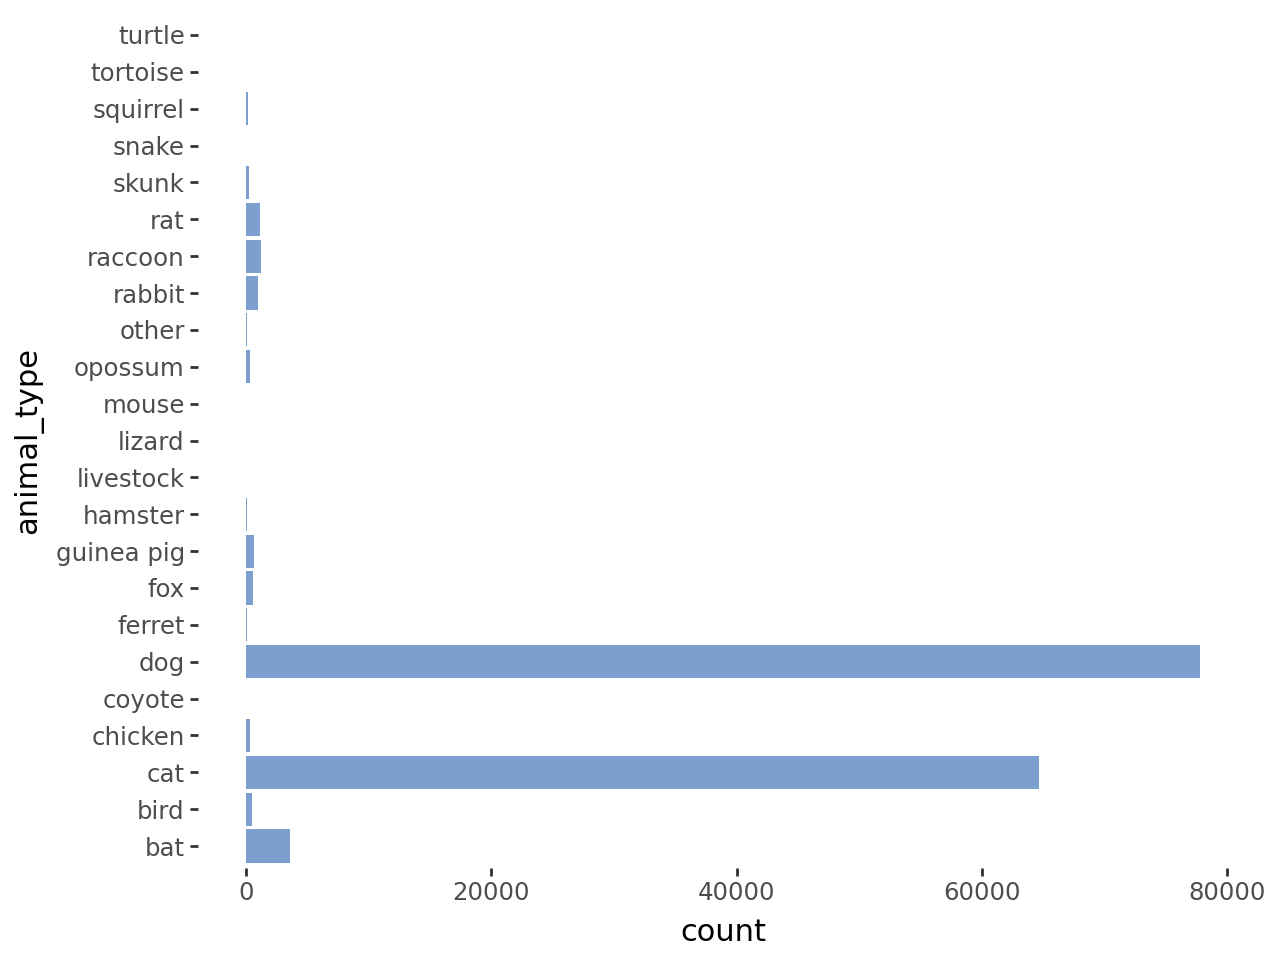

In [ ]:
#visual 1: animal types
g_1 = ggplot(data, aes(x='animal_type')) + geom_bar(fill= '#7B9FCF')+ coord_flip() + theme( # Turn off grid
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank()
    )
g_1

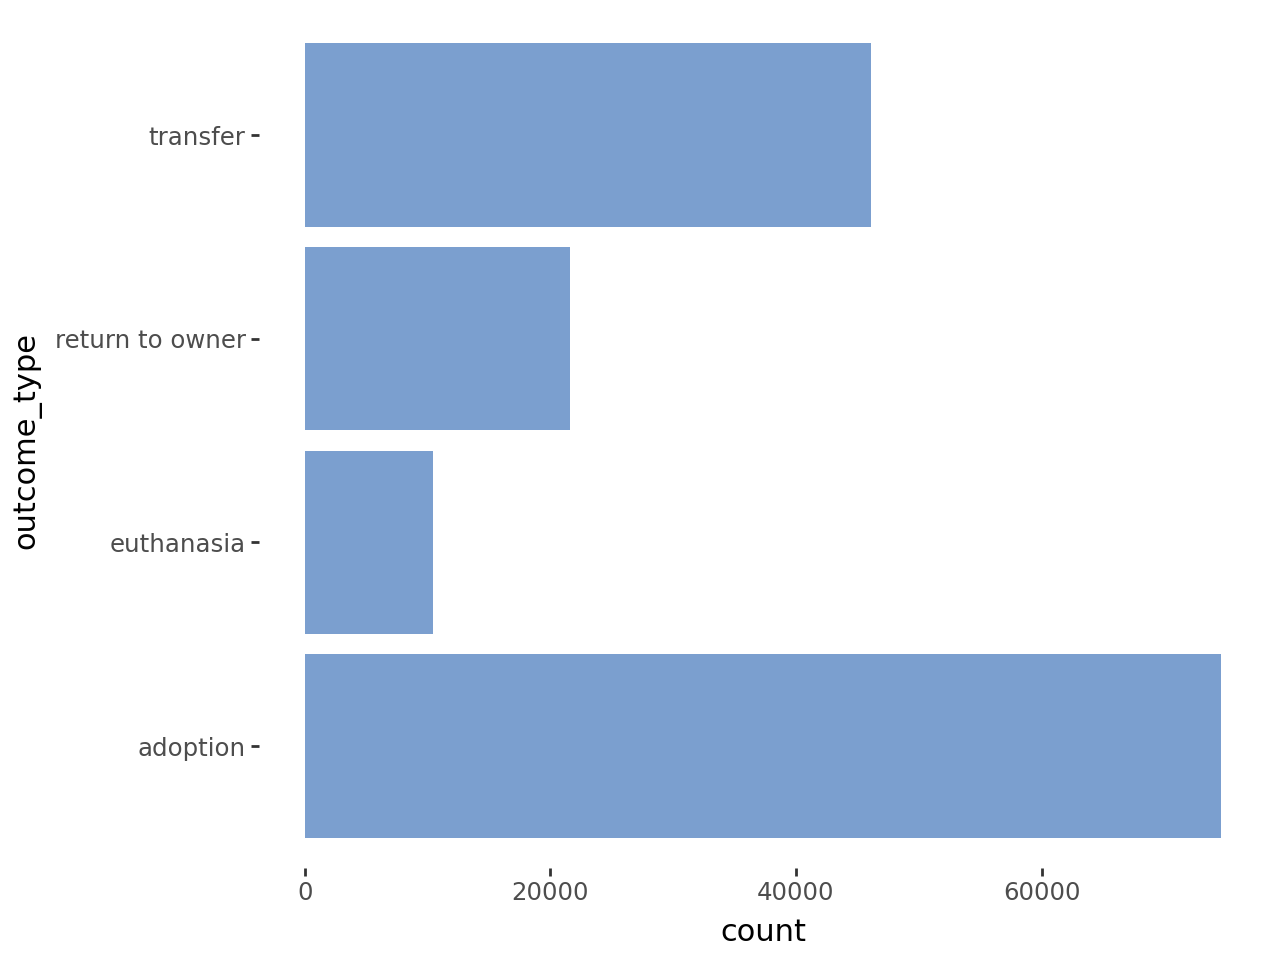

In [ ]:
#visual 2: Outcome types
g_2 = ggplot(data, aes(x='outcome_type')) + geom_bar(fill= '#7B9FCF')+ coord_flip() + theme( # Turn off grid
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank()
    )
g_2

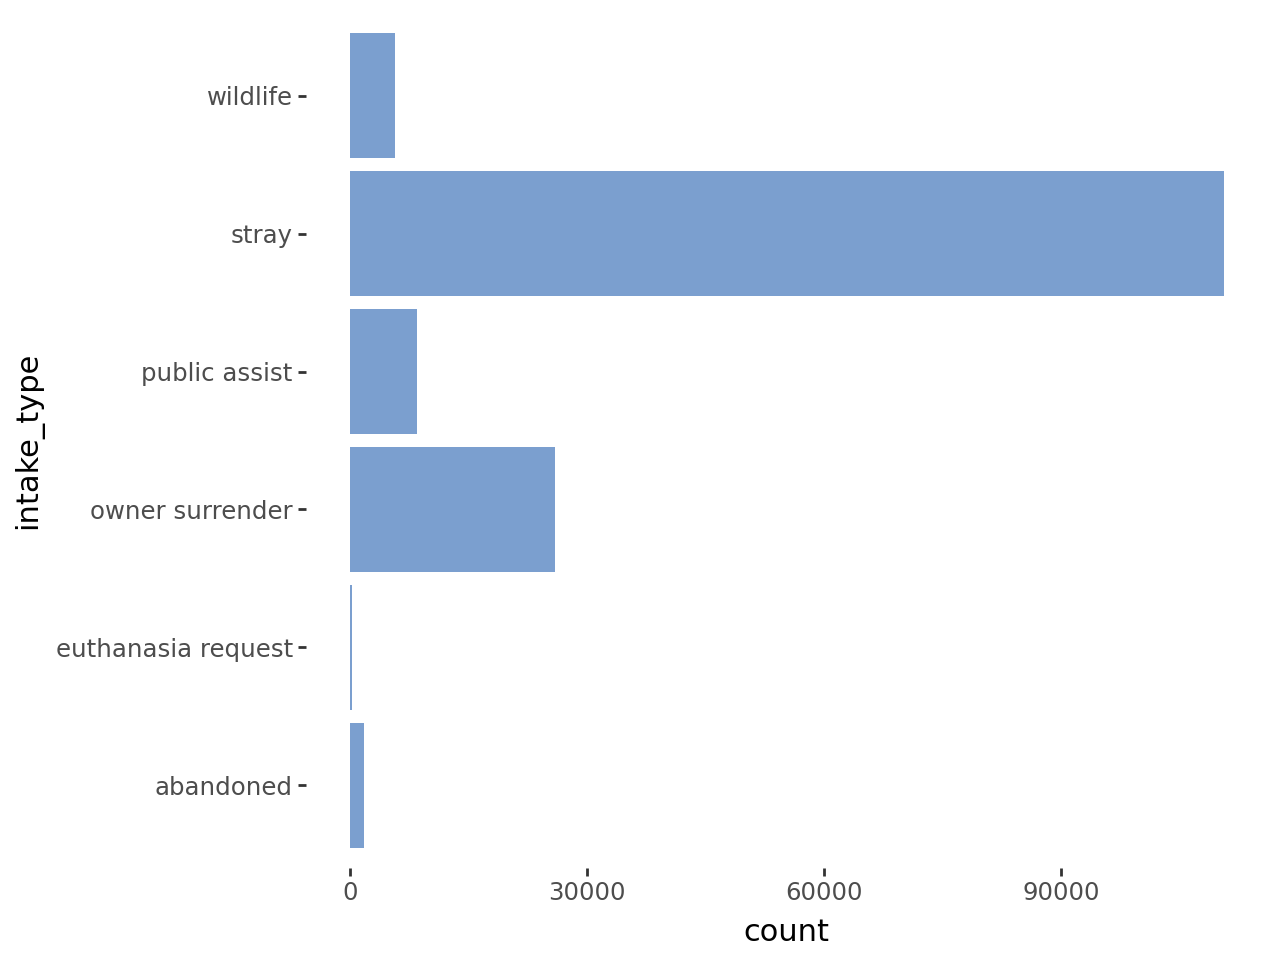

In [ ]:
#visual 3: intake type
g_3 = ggplot(data, aes(x='intake_type')) + geom_bar(fill= '#7B9FCF')+ coord_flip() + theme( # Turn off grid
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank()
    )
g_3

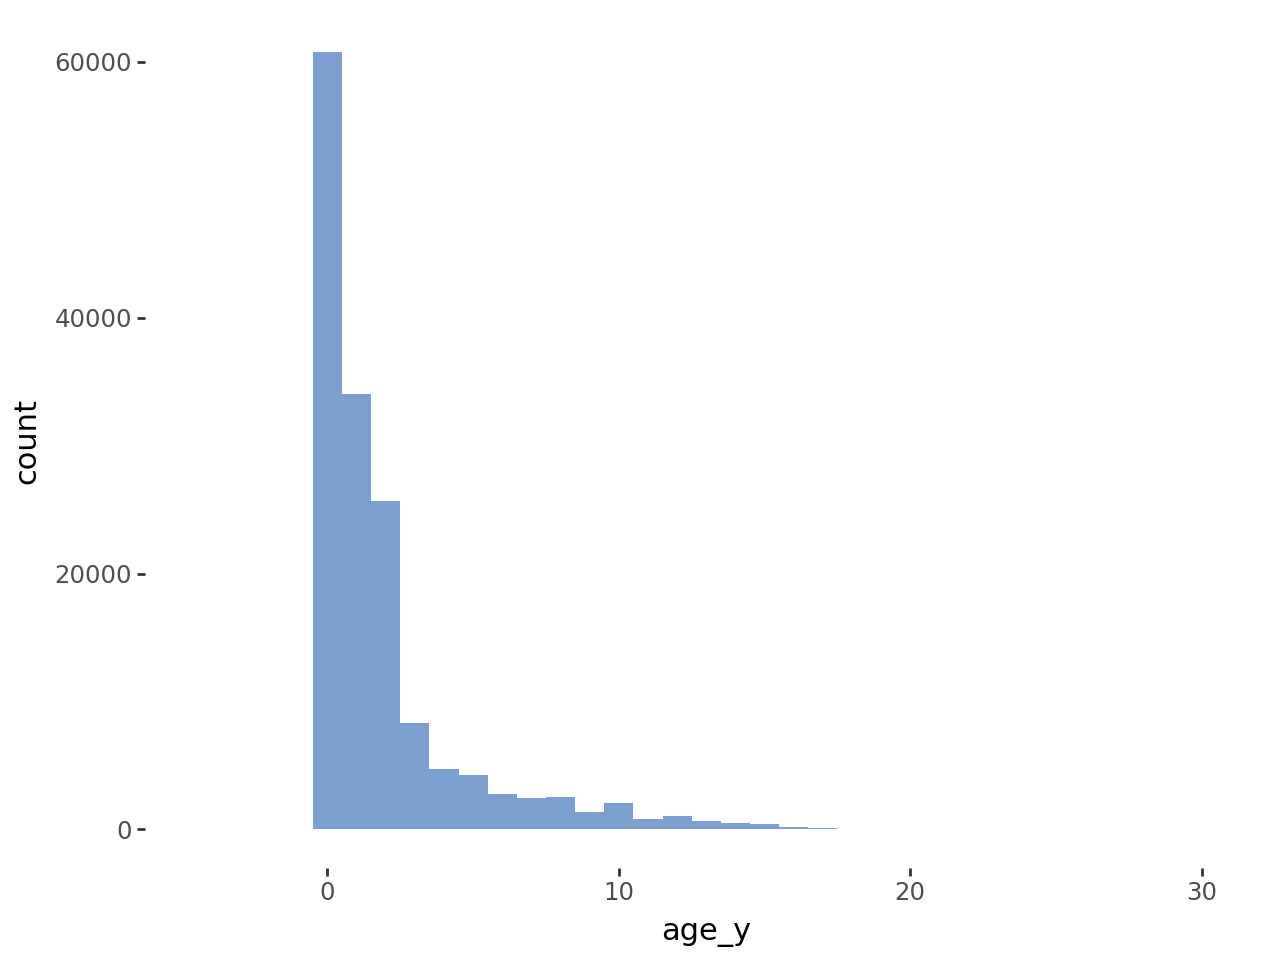

In [ ]:
#visual 4: age distribution
g_4 = ggplot(data, aes(x='age_y')) + geom_histogram(fill= '#7B9FCF', binwidth=1) + theme( # Turn off grid
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank()
    )
g_4

/usr/local/lib/python3.12/dist-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 333 rows containing non-finite values.
/usr/local/lib/python3.12/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


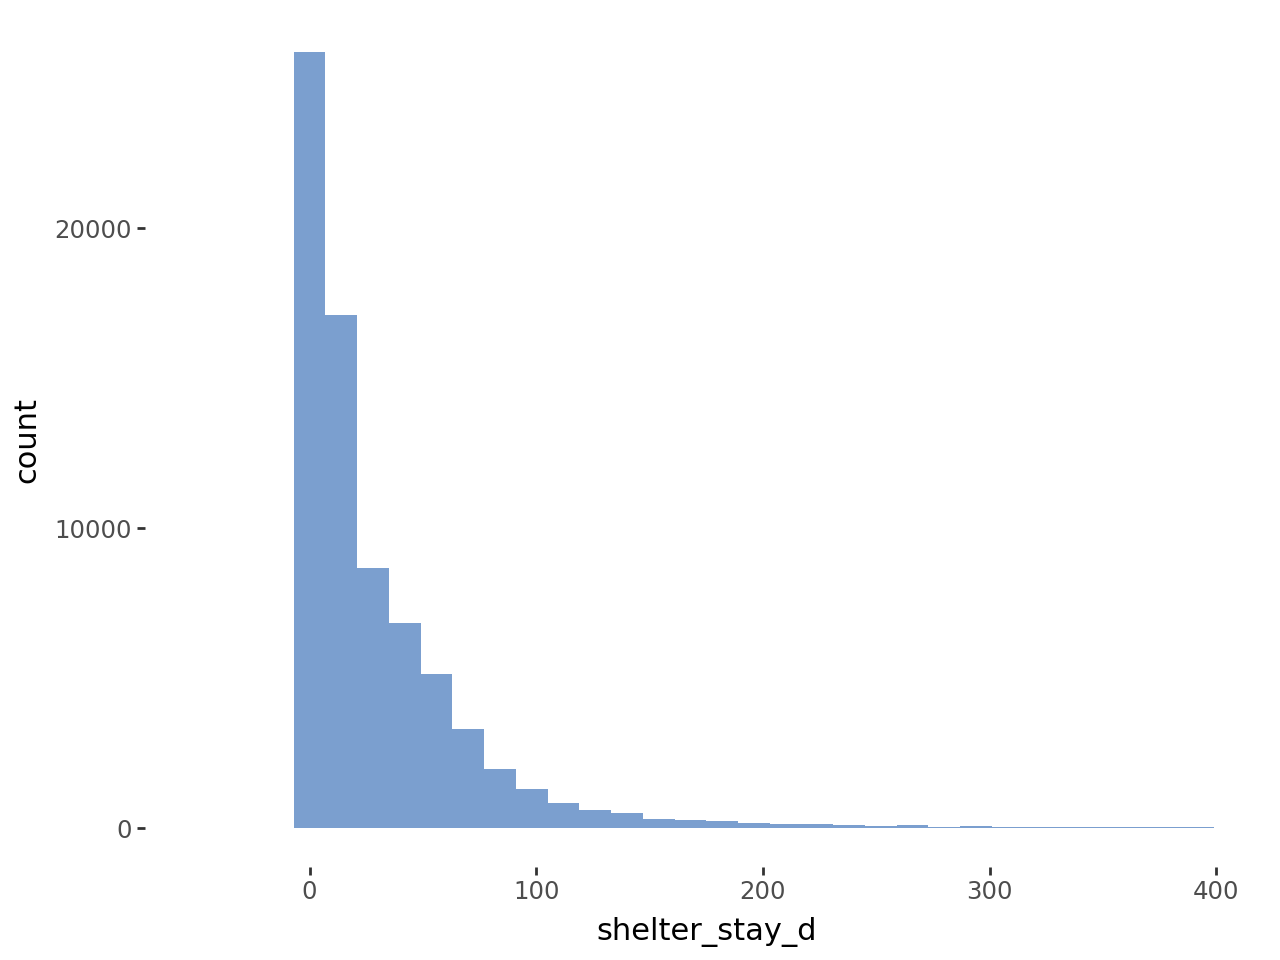

In [ ]:
#visual 5: duration in shelter distribution
g_5 = ggplot(data[data['outcome_type']=='adoption'], aes(x='shelter_stay_d')) + geom_histogram(fill= '#7B9FCF', binwidth=14) + theme( # Turn off grid
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank()
    ) + xlim(-50, 400)
g_5

#XGBoost 1: Multiclass Prediction

In [ ]:
#define Y, response var
Y =data['outcome_type']

# filter out features that have not enough hits
n=50 #set min threshold of datapoings for features
keeper_cols = [] #initialize keeper columns
throwaway_cols = []
for col in combined_matrix:
  if combined_matrix.loc[combined_matrix[col]!=0, col].count() < n:
    throwaway_cols.append(col)
  else:
    keeper_cols.append(col)

X = combined_matrix[keeper_cols].copy()
print(f"columns removed for <50 features: {throwaway_cols}")
#check sizes
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
print(f"X NaN count: {X.isna().sum().sum()}")
print(f"Y NaN count: {Y.isna().sum().sum()}")
print("shapes should match, NaN should be 0")

columns removed for <50 features: ['intake_condition_agonal', 'intake_condition_congenital', 'intake_condition_med urgent', 'intake_condition_neurologic', 'intake_condition_panleuk', 'intake_condition_parvo', 'intake_condition_space', 'intake_condition_unknown', 'animal_type_coyote', 'animal_type_livestock', 'animal_type_lizard', 'animal_type_mouse', 'animal_type_snake', 'animal_type_tortoise', 'animal_type_turtle', 'breed_abyssinian', 'breed_affenpinscher', 'breed_afghan hound', 'breed_african', 'breed_airedale terrier', 'breed_akbash', 'breed_alaskan klee kai', 'breed_american', 'breed_american curl shorthair', 'breed_american sable', 'breed_american wirehair', 'breed_angora', 'breed_angora-english', 'breed_angora-french', 'breed_angora-satin', 'breed_armadillo', 'breed_australian terrier', 'breed_australorp', 'breed_balinese', 'breed_bantam', 'breed_barred rock', 'breed_bearded collie', 'breed_bearded dragon', 'breed_beauceron', 'breed_bedlington terr', 'breed_belgian hare', 'breed_

In [ ]:
#Sampling for train and test

X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=0.3,
    random_state=42,
    stratify=Y    #stratify over response var
)

#encode y
le = LabelEncoder()
le.fit(y_train)
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.fit_transform(y_test)
print(f"num_class: {(y_train_enc.max()+1).astype(int)}")

num_class: 4


In [ ]:
## XGboost Model
dtrain = xgb.DMatrix(data=X_train.values, label=y_train_enc)
dtest  = xgb.DMatrix(data=X_test.values,  label=y_test_enc)

#tuned params
num_boost_round = 499
min_child_weight = 5
max_depth = 10
eta = 0.3
subsample = 0.9
colsample_bytree = 0.8
gamma = 0.05

#set params
params = {
        "objective": "multi:softmax", # Set objective
        "eval_metric": ["mlogloss", "merror"],
        "seed": 42, # set seed
        "min_child_weight": min_child_weight,
        "max_depth": max_depth,
        "eta": eta,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "gamma": gamma,
        "num_class": 4 # set numclass to #responses
    }
num_boost_round = num_boost_round # Set number of rounds

watchlist = [(dtrain, "train")] # Set data for evaluation
boost1 = xgb.train(params, # Set parameters
                    dtrain,  # Set training data
                    num_boost_round=num_boost_round, # Set number of rounds
                    verbose_eval=100,
                    evals=watchlist)

[0]	train-mlogloss:0.97570	train-merror:0.16835
[100]	train-mlogloss:0.26775	train-merror:0.09881
[200]	train-mlogloss:0.19690	train-merror:0.06432
[300]	train-mlogloss:0.15087	train-merror:0.04116
[400]	train-mlogloss:0.11687	train-merror:0.02494
[498]	train-mlogloss:0.09196	train-merror:0.01422



Confusion matrix:


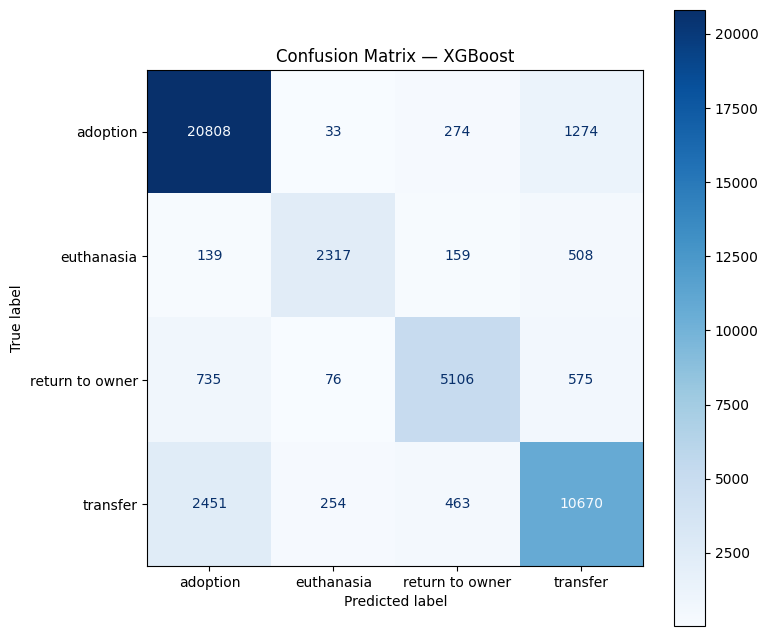


Accuracy:
test accuracy: 0.8485886305135029
train accuracy: 0.9857802625182305


In [ ]:
#predictions
test_pred = boost1.predict(dtest) # Create predictions
train_pred = boost1.predict(dtrain)
#confusion matrix
print("\nConfusion matrix:")
cm = confusion_matrix(y_test_enc, test_pred)

fig, ax = plt.subplots(figsize=(8, 8)) # Create figure and axes with desired size
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", ax=ax) # Pass the axes to disp.plot()

plt.title("Confusion Matrix — XGBoost") # Set title
plt.show() # Display plot
print("\nAccuracy:")
print(f"test accuracy: {accuracy_score(y_test_enc, test_pred)}") # Get classification report
print(f"train accuracy: {accuracy_score(y_train_enc, train_pred)}") # Get classification report

In [ ]:
#SHAP
# Create TreeExplainer and compute SHAP values
#explainer = shap.TreeExplainer(boost1)
#shap_values = explainer(X_train)

# Interactive JS init
#shap.initjs()

In [ ]:
# Beeswarm for binary
#shap.plots.beeswarm(shap_values, max_display=40)  # matplotlib figure

#XGBoost 2: Gamma Deviance Regression

In [13]:
reg_data = pd.merge(combined_matrix, data['outcome_type'], left_index=True, right_index=True, how='inner')
adopted_animals = reg_data[(reg_data['outcome_type']=='adoption') & (reg_data['shelter_stay_d']>0) & (reg_data['shelter_stay_d']<=400)]

n=50 #set min threshold of datapoings for features
keeper_cols = [] #initialize keeper columns
throwaway_cols = []
for col in adopted_animals:
  if adopted_animals.loc[adopted_animals[col]!=0, col].count() < n:
    throwaway_cols.append(col)
  else:
    keeper_cols.append(col)

X = adopted_animals[keeper_cols].drop(columns=['outcome_type', 'shelter_stay_d'])
Y = adopted_animals['shelter_stay_d']
print(f"columns removed for <50 features: {throwaway_cols}")
#check sizes
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
print(f"X NaN count: {X.isna().sum().sum()}")
print(f"Y NaN count: {Y.isna().sum().sum()}")
print("shapes should match, NaN should be 0")

columns removed for <50 features: ['intake_type_euthanasia request', 'intake_type_wildlife', 'intake_condition_agonal', 'intake_condition_behavior', 'intake_condition_congenital', 'intake_condition_feral', 'intake_condition_med attn', 'intake_condition_med urgent', 'intake_condition_neurologic', 'intake_condition_panleuk', 'intake_condition_parvo', 'intake_condition_space', 'intake_condition_unknown', 'animal_type_bat', 'animal_type_coyote', 'animal_type_hamster', 'animal_type_livestock', 'animal_type_lizard', 'animal_type_mouse', 'animal_type_opossum', 'animal_type_other', 'animal_type_raccoon', 'animal_type_skunk', 'animal_type_snake', 'animal_type_squirrel', 'animal_type_tortoise', 'animal_type_turtle', 'breed_abyssinian', 'breed_affenpinscher', 'breed_afghan hound', 'breed_african', 'breed_airedale terrier', 'breed_akbash', 'breed_alaskan klee kai', 'breed_alaskan malamute', 'breed_american', 'breed_american curl shorthair', 'breed_american eskimo', 'breed_american hound', 'breed_a

In [14]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=0.3,
    random_state=42,
)

In [15]:
#tuned parameters
num_boost_round = 384
min_child_weight = 30
max_depth = 8
eta = 0.10
subsample = 1.0
colsample_bytree = 0.7
gamma = 0.2

## XGboost Model
dtrain = xgb.DMatrix(data=X_train.values, label=y_train)
dtest  = xgb.DMatrix(data=X_test.values,  label=y_test)

#set params
params = {
        "objective": "reg:gamma", # Set objective
        "eval_metric": ["gamma-deviance"],  # set eval
        "seed": 42, # set seed
        "tree_method": "hist",
        "max_depth": max_depth,
        "min_child_weight": min_child_weight,
        "eta": eta,
        "subsample": subsample,
        'colsample_bytree': colsample_bytree,
        'gamma': gamma

        }

watchlist = [(dtrain, "train")] # Set data for evaluation
boost2 = xgb.train(params, # Set parameters
                    dtrain,  # Set training data
                    num_boost_round=num_boost_round, # Set number of rounds
                    verbose_eval=100,
                    evals=watchlist)

[0]	train-gamma-deviance:1.26251
[100]	train-gamma-deviance:0.61047
[200]	train-gamma-deviance:0.55916
[300]	train-gamma-deviance:0.53804
[383]	train-gamma-deviance:0.53804


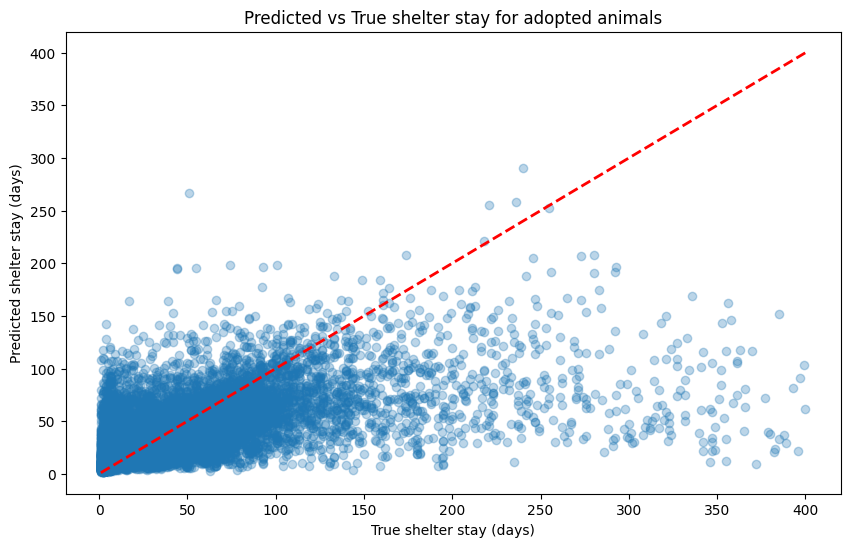


Gamma Deviance (test set):
19.58964706786091

Null Deviance (test set - predicting mean of y_test):
40.32571205412543

Gamma Deviance (train set):
15.590646081623584


In [28]:
#predictions
test_pred = boost2.predict(dtest) # Create predictions

# Plotting y_test vs test_pred for comparison
plt.figure(figsize=(10, 6))
plt.scatter(x = y_test, y= test_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True shelter stay (days)')
plt.ylabel('Predicted shelter stay (days)')
plt.title('Predicted vs True shelter stay for adopted animals')
plt.grid(False)
plt.show()

import numpy as np

def gamma_deviance_score(y_true, y_pred):
    # Ensure y_true and y_pred are positive for gamma distribution
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    # Add a small epsilon to avoid log(0) or division by zero if values are 0 or negative.
    y_true[y_true <= 0] = np.finfo(float).eps
    y_pred[y_pred <= 0] = np.finfo(float).eps

    # Gamma deviance formula: 2 * sum(y_true * log(y_true/y_pred) - (y_true - y_pred)) / n_samples
    deviance = 2 * (y_true * np.log(y_true / y_pred) - (y_true - y_pred))
    return np.mean(deviance)

print("\nGamma Deviance (test set):")
print(gamma_deviance_score(y_test, test_pred))

# Calculate Null Deviance
y_test_mean = np.full_like(y_test, fill_value=y_test.mean())
print("\nNull Deviance (test set - predicting mean of y_test):")
print(gamma_deviance_score(y_test, y_test_mean))

# Calculate Gamma Deviance for training set
train_pred = boost2.predict(dtrain)
print("\nGamma Deviance (train set):")
print(gamma_deviance_score(y_train, train_pred))

In [18]:
#SHAP
# Create TreeExplainer and compute SHAP values
explainer = shap.TreeExplainer(boost2)
shap_values = explainer(X_train)

# Interactive JS init
shap.initjs()

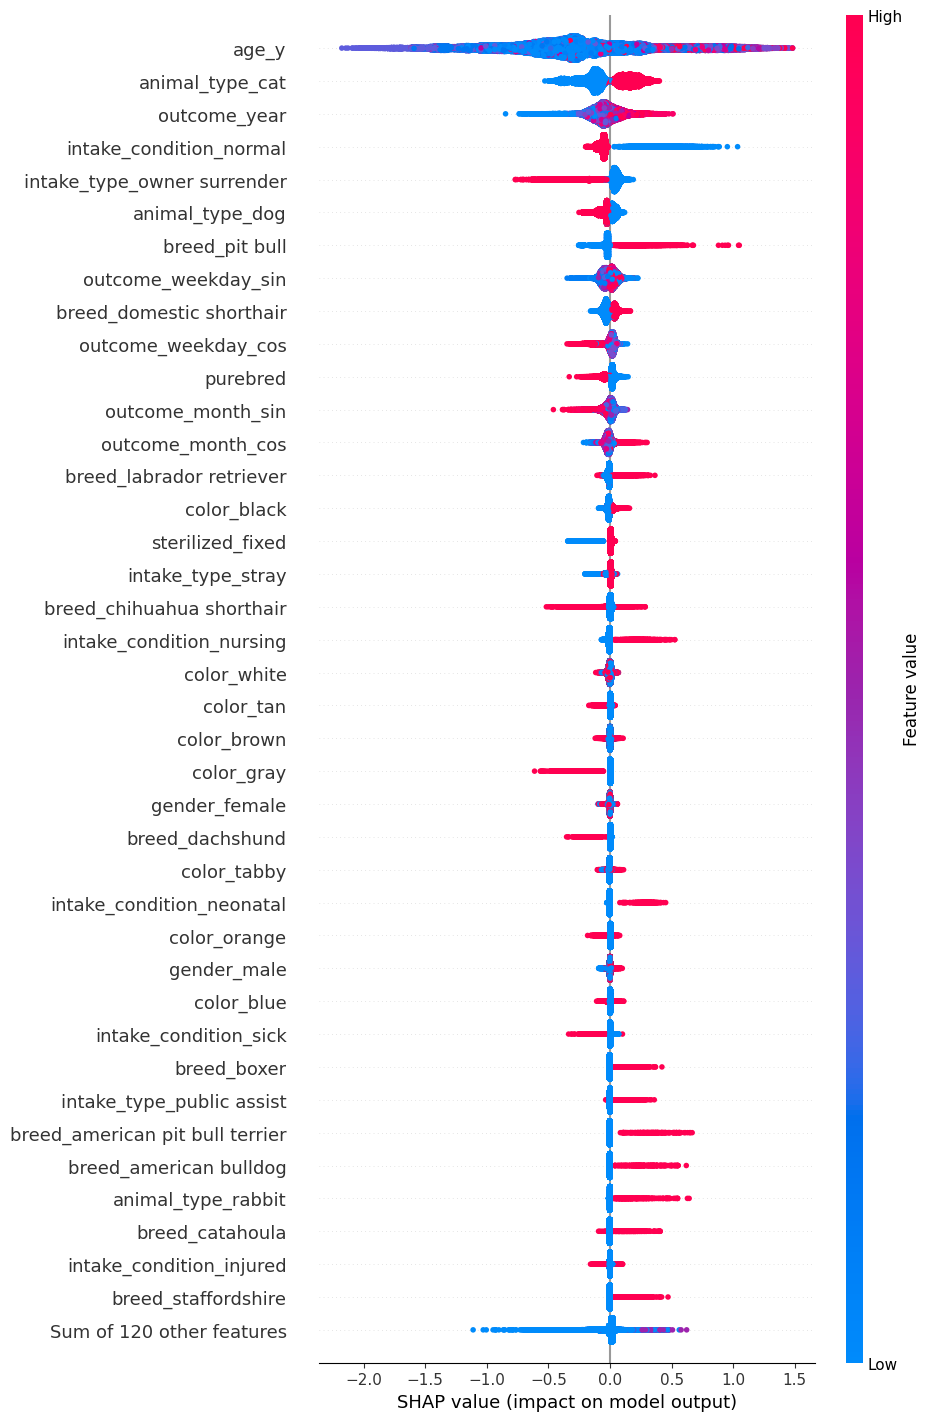

In [19]:
# Beeswarm for binary
shap.plots.beeswarm(shap_values, max_display=40)  # matplotlib figure

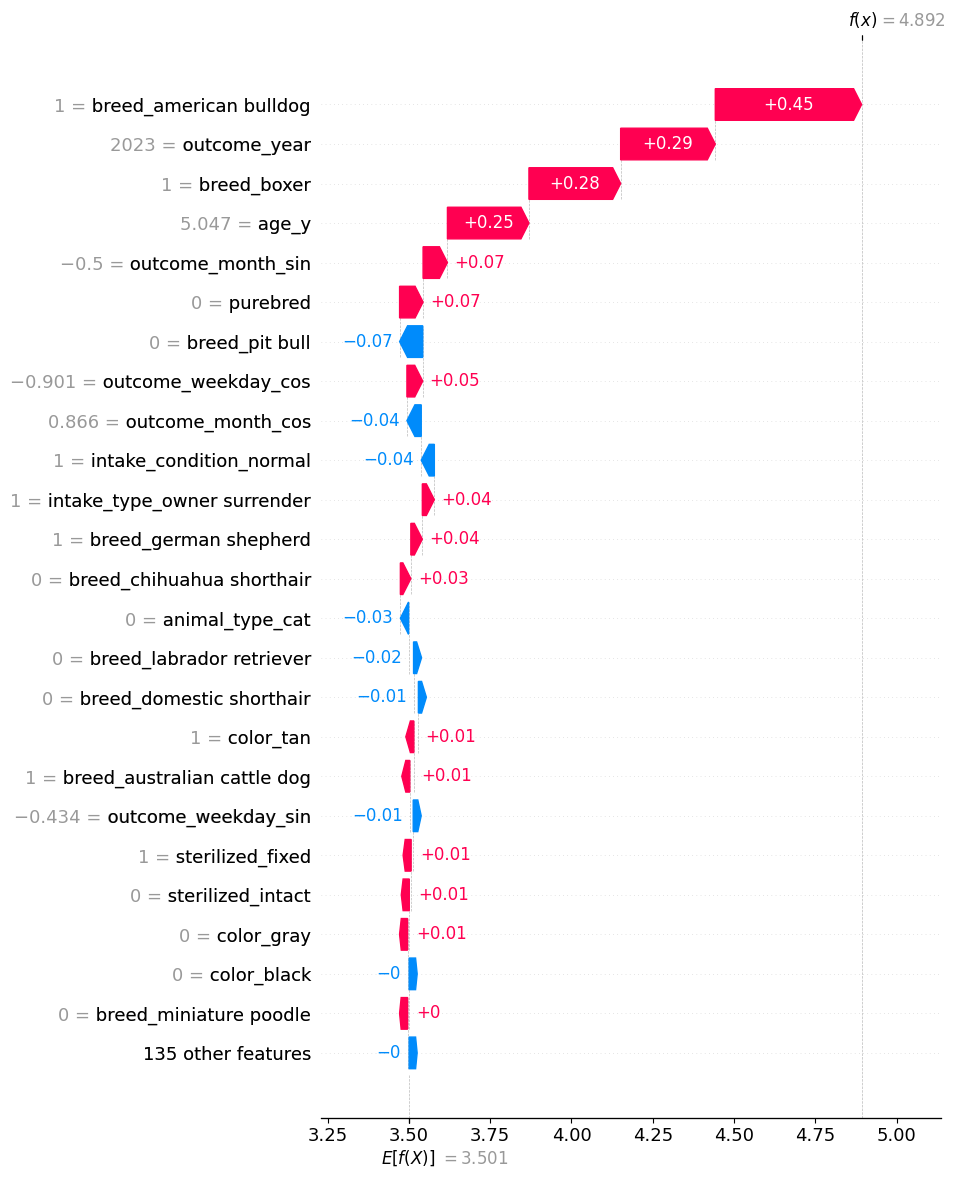

true shelter stay for athena: 289 days


In [20]:
row_idx = 'athena'

# Get the integer location of the animal_id 'athena' in the training data's index
# This assumes 'athena' is present in X_train.index
if row_idx in X_train.index:
    idx_pos = X_train.index.get_loc(row_idx)
    # Waterfall plot using the integer position
    shap.plots.waterfall(shap_values[idx_pos], max_display=25)
else:
    print(f"Animal ID '{row_idx}' not found in the training data index.")
print(f"true shelter stay for {row_idx}: {y_train.loc[row_idx].astype(int)} days")

# Adoption Factors

In [ ]:
#pull out response var
Y =data['outcome_type']
#merge
temp1 = pd.merge(data_dummied, breed_matrix, left_index=True, right_index=True, how='inner')
combined_matrix = pd.merge(temp1, color_matrix, left_index=True, right_index=True, how='inner')

#filter out features that have not enough hits
n=50 #set min threshold of datapoings for features
keeper_cols = [] #initialize keeper columns
throwaway_cols = []
for col in combined_matrix:
  if combined_matrix.loc[combined_matrix[col]!=0, col].count() < n:
    throwaway_cols.append(col)
  else:
    keeper_cols.append(col)

X = combined_matrix[keeper_cols].copy()
print(f"columns removed for <50 features: {throwaway_cols}")
#check sizes
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
print(f"X NaN count: {X.isna().sum().sum()}")
print(f"Y NaN count: {Y.isna().sum().sum()}")
print("shapes should match, NaN should be 0")

#encoding Xtrain and Ytrain
X_train = X
y_train = Y.map(lambda x: 1 if x=='adoption' else 0)


columns removed for <50 features: ['intake_condition_agonal', 'intake_condition_congenital', 'intake_condition_med urgent', 'intake_condition_neurologic', 'intake_condition_panleuk', 'intake_condition_parvo', 'intake_condition_space', 'intake_condition_unknown', 'animal_type_coyote', 'animal_type_livestock', 'animal_type_lizard', 'animal_type_mouse', 'animal_type_snake', 'animal_type_tortoise', 'animal_type_turtle', 'breed_abyssinian', 'breed_affenpinscher', 'breed_afghan hound', 'breed_african', 'breed_airedale terrier', 'breed_akbash', 'breed_alaskan klee kai', 'breed_american', 'breed_american curl shorthair', 'breed_american sable', 'breed_american wirehair', 'breed_angora', 'breed_angora-english', 'breed_angora-french', 'breed_angora-satin', 'breed_armadillo', 'breed_australian terrier', 'breed_australorp', 'breed_balinese', 'breed_bantam', 'breed_barred rock', 'breed_bearded collie', 'breed_bearded dragon', 'breed_beauceron', 'breed_bedlington terr', 'breed_belgian hare', 'breed_

In [ ]:
## XGboost Model
dtrain = xgb.DMatrix(data=X_train.values, label=y_train)

#set params
params = {
        "objective": "binary:logistic", # Set objective
        "eval_metric": ["auc", "error"],  # Track both AUC and error
        "seed": 42, # set seed
    }

watchlist = [(dtrain, "train")] # Set data for evaluation
boost_outcome_varstrength = xgb.train(params, # Set parameters
                    dtrain,  # Set training data
                    num_boost_round=500, # Set number of rounds
                    verbose_eval=100,
                    evals=watchlist)

[0]	train-auc:0.93887	train-error:0.12990
[100]	train-auc:0.95947	train-error:0.10541
[200]	train-auc:0.96536	train-error:0.09844
[300]	train-auc:0.96921	train-error:0.09358
[400]	train-auc:0.97267	train-error:0.08809
[499]	train-auc:0.97534	train-error:0.08396


In [ ]:
#SHAP
# Create TreeExplainer and compute SHAP values
explainer = shap.TreeExplainer(boost_outcome_varstrength)
shap_values = explainer(X_train)

# Interactive JS init
shap.initjs()

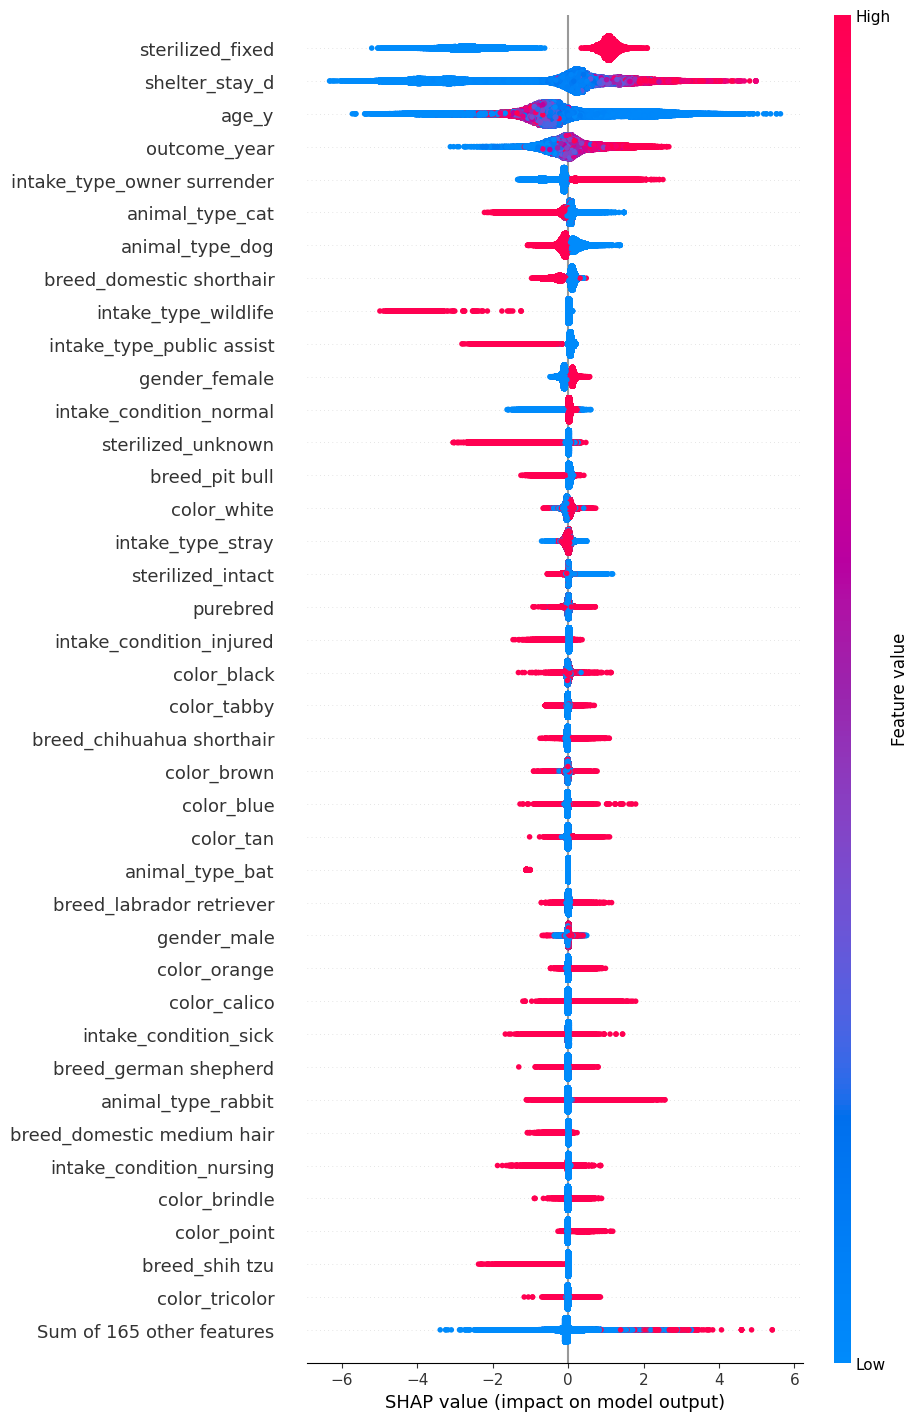

In [ ]:
# Beeswarm for binary
shap.plots.beeswarm(shap_values, max_display=40)  # matplotlib figure

# Appendix A: tuning for multiclass xgboost

In [ ]:
tuningflag = False

In [ ]:
if tuningflag:
  #tuning iterations
  params = {
      "objective": "multi:softmax", # Set objective
      "eval_metric": ["mlogloss", "merror"],
      "eta": 0.01,                       # Set learning rate
      "tree_method": "hist",
      "seed": 111111,
      "nthread": 1,                     # Parallel threads
      "num_class": 4 # set numclass to #responses
  }

  # Run CV inside XGBoost
  cv_res = xgb.cv(
      params=params,
      dtrain=dtrain,              # Training data (DMatrix)
      num_boost_round=500,       # Number of rounds
      nfold=5,                    # 5-fold CV
      verbose_eval=100,            # Print every 20 iters
      shuffle=True,
  )

[0]	train-mlogloss:1.29199+0.00029	train-merror:0.51943+0.00074	test-mlogloss:1.29205+0.00055	test-merror:0.51943+0.00297
[100]	train-mlogloss:0.73988+0.00099	train-merror:0.18246+0.00079	test-mlogloss:0.74359+0.00256	test-merror:0.18499+0.00251
[200]	train-mlogloss:0.57451+0.00108	train-merror:0.17802+0.00065	test-mlogloss:0.58112+0.00417	test-merror:0.18076+0.00300
[300]	train-mlogloss:0.51109+0.00117	train-merror:0.17398+0.00078	test-mlogloss:0.52056+0.00493	test-merror:0.17727+0.00261
[400]	train-mlogloss:0.48214+0.00107	train-merror:0.17091+0.00050	test-mlogloss:0.49446+0.00525	test-merror:0.17465+0.00311
[499]	train-mlogloss:0.46618+0.00099	train-merror:0.16747+0.00042	test-mlogloss:0.48130+0.00515	test-merror:0.17244+0.00273


Best iteration (by min test error): 499
Min test error at best iter: 0.172428
Test mlogloss at best iter: 0.481408


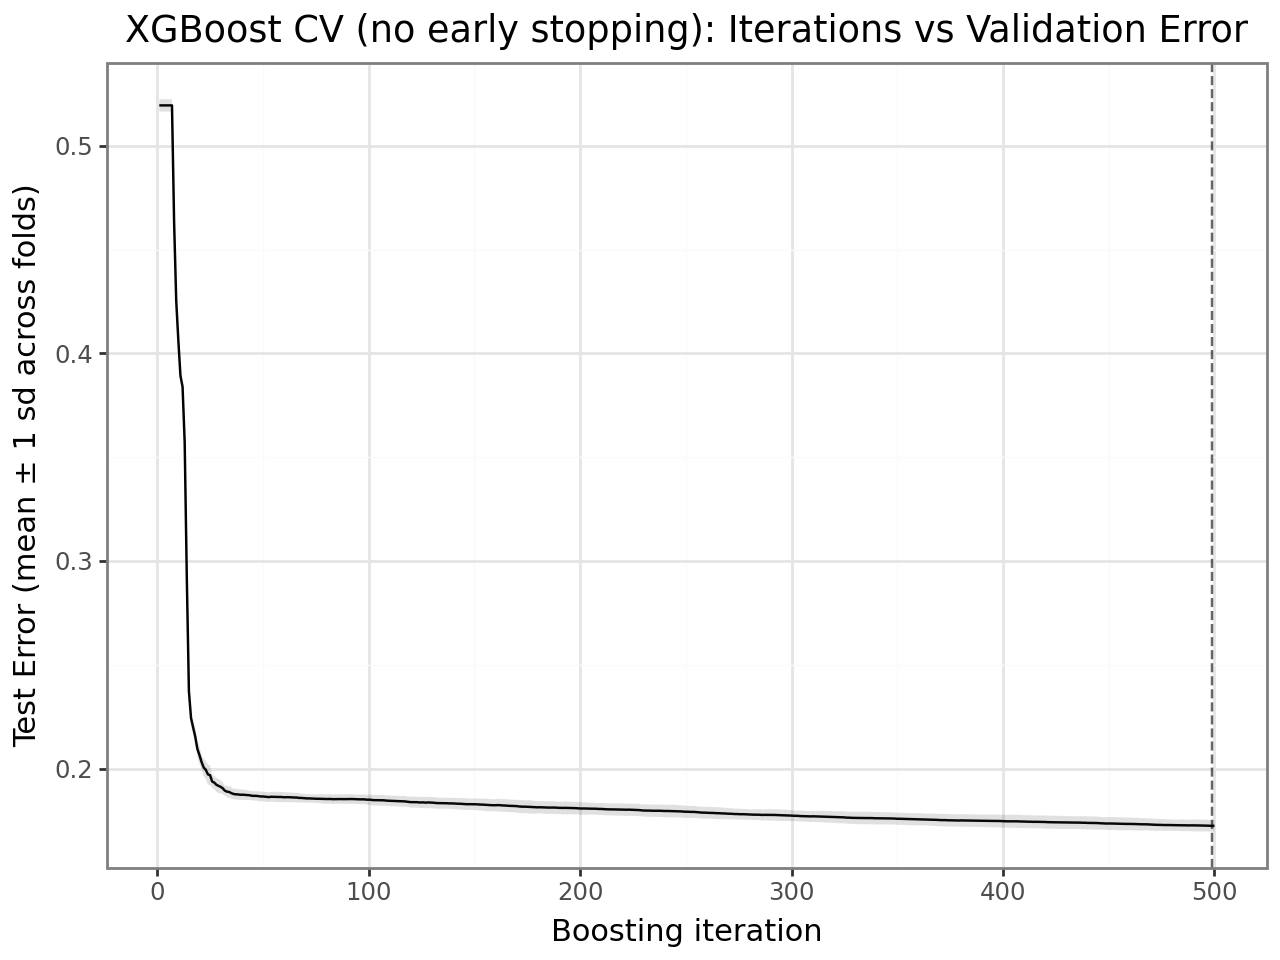

In [ ]:
if tuningflag:
  # Identify best iteration
  best_idx = cv_res['test-merror-mean'].idxmin()
  best_iter = int(best_idx) + 1 # Increment by 1 to get iteration
  best_err  = float(cv_res.loc[best_idx, 'test-merror-mean']) # Extract test error
  best_mlogloss  = float(cv_res.loc[best_idx, 'test-mlogloss-mean']) # Extract test mlogloss

  # Print results
  print(f"Best iteration (by min test error): {best_iter}")
  print(f"Min test error at best iter: {best_err:.6f}")
  print(f"Test mlogloss at best iter: {best_mlogloss:.6f}")

  df_plot = cv_res.reset_index().rename(columns={"index": "iter"})
  df_plot["iter"] = df_plot["iter"] + 1  # 1-based

  # Safe column names (hyphens -> underscores) and ribbon bounds
  df_plot = df_plot.rename(columns=lambda c: c.replace("-", "_"))
  df_plot["test_error_lower"] = df_plot["test_merror_mean"] - df_plot["test_merror_std"]
  df_plot["test_error_upper"] = df_plot["test_merror_mean"] + df_plot["test_merror_std"]

  # Create plot
  p_err = (
      ggplot(df_plot, # Set data
            aes(x="iter", y="test_merror_mean")) # Set X and Y
      + geom_line() # Set line
      + geom_ribbon(aes(ymin="test_error_lower", ymax="test_error_upper"), alpha=0.15) # Set error bounds
      + geom_vline(xintercept=best_iter, linetype="dashed", alpha=0.6) # Add vertical line at best iteration
      + theme_bw() # Set theme
      + labs( # Set labels
          title="XGBoost CV (no early stopping): Iterations vs Validation Error",
          x="Boosting iteration",
          y="Test Error (mean ± 1 sd across folds)"
      )
  )
  # View plot
  display(p_err)

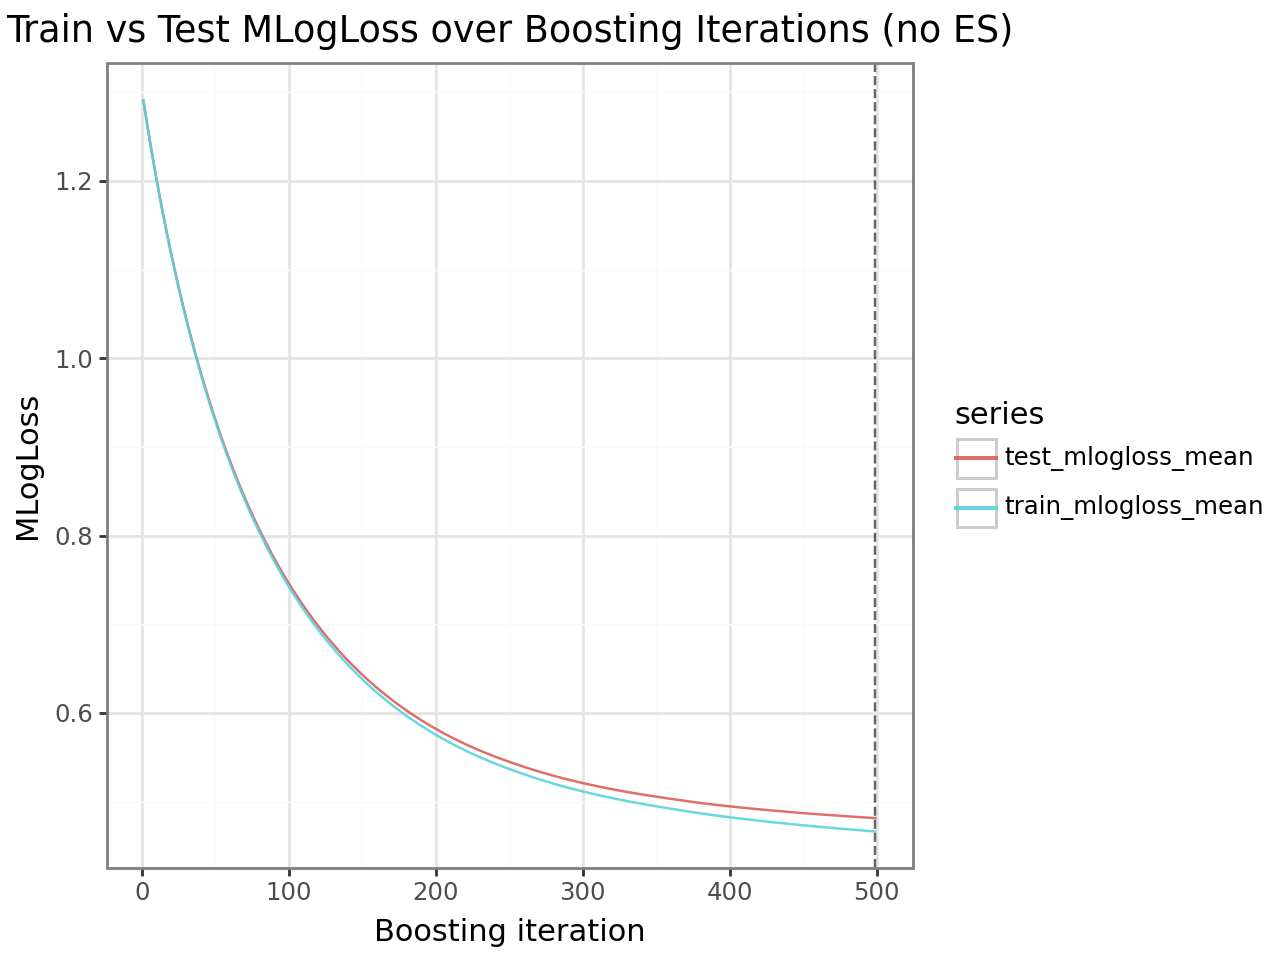

In [ ]:
if tuningflag:
  df_long = df_plot.melt( # Melt data
      id_vars=["iter"],
      value_vars=["train_mlogloss_mean", "test_mlogloss_mean"],
      var_name="series",
      value_name="mlogloss"
  )
  # Create plot
  p_err_both = (
      ggplot(df_long, # Set data
            aes(x="iter", y="mlogloss", color="series")) # Set aesthetics
      + geom_line(alpha=0.9) # Set geom line
      + geom_vline(xintercept=best_iter, linetype="dashed", alpha=0.6) # Add vertical line for best iteration
      + theme_bw() # Set theme
      + labs( # Set labels
          title="Train vs Test MLogLoss over Boosting Iterations (no ES)",
          x="Boosting iteration",
          y="MLogLoss"
      )
  )
  # Display plot
  display(p_err_both)

In [ ]:
if tuningflag:
  #Tune ETA
  # Set ETA values to try
  etas = [0.3, 0.2, 0.1, 0.05, 0.01]
  # Set base parameters
  base_params = {
      "objective": "multi:softmax", # Set objective to multiclass
      "eval_metric": ["mlogloss", "merror"],  # set eval metrics to multiclass
      "tree_method": "hist",
      "seed": 111111,
      "nthread": 1,                     # Parallel threads
      "num_class": 4 # add num_class for multiclass objective
  }

  ### Be careful this can take a long time to run ###
  curves = []     # per-iteration logs for plotting
  summaries = []  # one row per eta
  # For each learning rate
  for eta in tqdm(etas, desc="Learning-rate CV (serial)"):
      params = base_params.copy() # Create copy of parmameters
      params["eta"] = float(eta) # Update ETA value
      # Apply xgb.cv
      cv = xgb.cv(
          params=params, # Set parameters
          dtrain=dtrain, # Set training data
          num_boost_round=best_iter,  # Use optimal num_boost_round from previous tuning
          nfold=5, # Set folds for cross validation
          early_stopping_rounds=100, # Set early stopping rounds
          shuffle=True,
          verbose_eval=False,
          seed=111111,
      )

      # Extract data for model performance
      df_log = cv.reset_index().rename(columns={"index": "iter"})
      df_log["iter"] = df_log["iter"] + 1 # Increment iterations to get real number
      # fix hyphenated column names for plotnine
      df_log = df_log.rename(columns=lambda c: c.replace("-", "_"))
      df_log["eta"] = str(eta) # Store ETA value as a string
      curves.append(df_log) # Add values to data store

      # Identify best iteration based on test-merror-mean
      best_round = len(cv)
      best_row = cv.iloc[best_round - 1] # Identify best row


      best_merror = float(best_row["test-merror-mean"]) # Extract best merror value
      # Store results
      summaries.append({"eta": eta, "best_round": best_round, "test_merror": best_merror})

  # Combine curve data
  curves_df = pd.concat(curves, ignore_index=True)
  # Create data frame of result data, sorting by test_merror
  summ_df = pd.DataFrame(summaries).sort_values(
      ["test_merror"],
      ascending=True
  ).reset_index(drop=True)

  display(summ_df.head())

Learning-rate CV (serial): 100%|██████████| 5/5 [34:13<00:00, 410.72s/it]


,eta,best_round,test_merror
0,0.30,349,0.160525
1,0.20,499,0.160672
2,0.10,499,0.162723
3,0.05,499,0.164554
4,0.01,499,0.172474


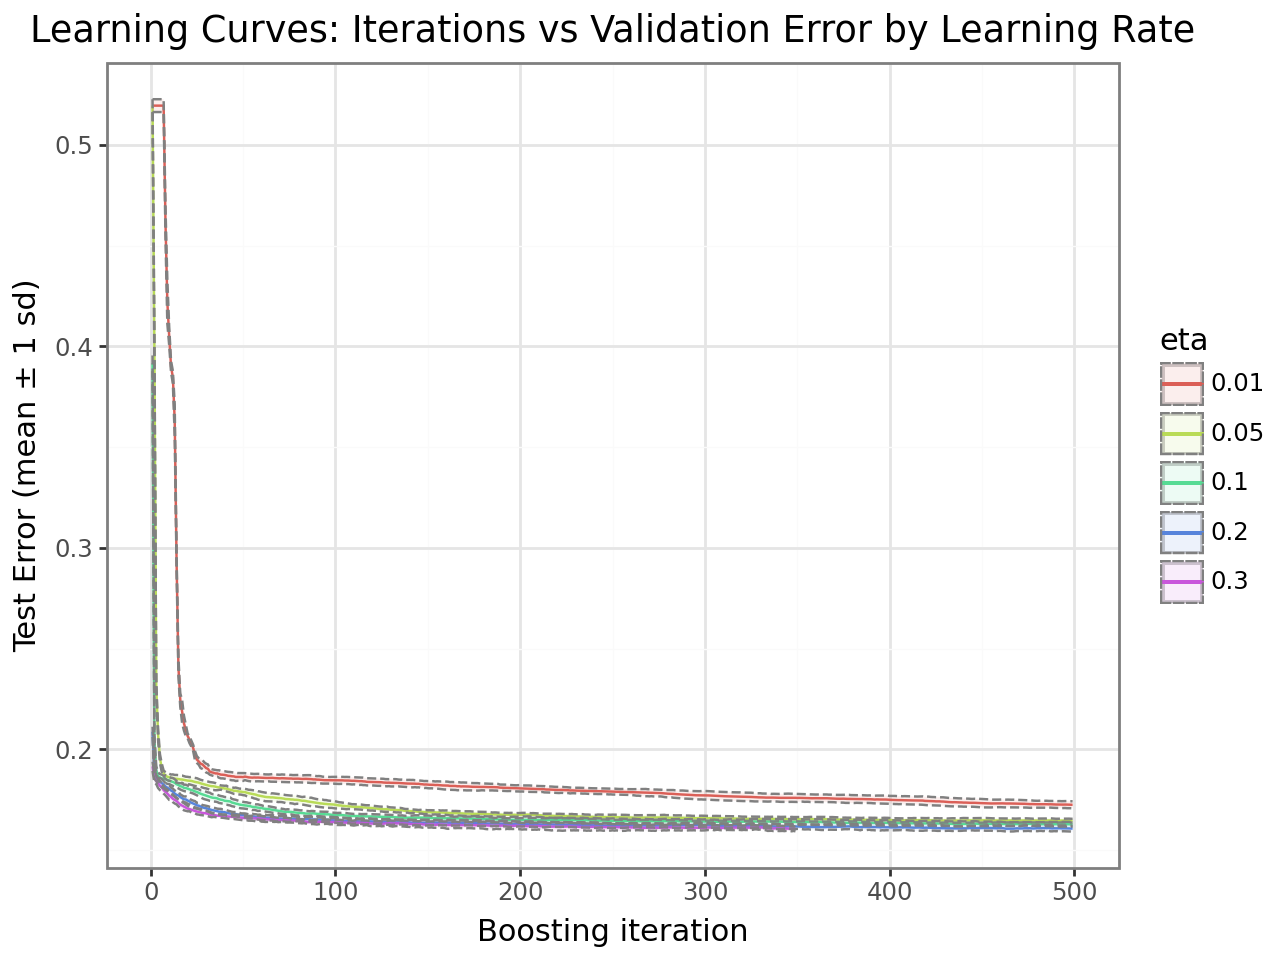


Selected eta=0.3 with best_round=349, test_merror=0.160525


In [ ]:
if tuningflag:
  # Precompute ribbons (mean ± 1 sd) per-eta
  curves_df["y_lower"] = curves_df["test_merror_mean"] - curves_df["test_merror_std"]
  curves_df["y_upper"] = curves_df["test_merror_mean"] + curves_df["test_merror_std"]

  # Create plot
  p_lr = (
      ggplot(curves_df,  # Set dataset
            aes(x="iter", y="test_merror_mean", color="eta", group="eta")) # Set Aesthetics
      + geom_line() # Set geom line
      + geom_ribbon(aes(ymin="y_lower", ymax="y_upper", fill="eta"), linetype="dashed", alpha=0.1, color="grey") # Add error bars
      + theme_bw() # Set theme
      + labs( # Set labels
          title="Learning Curves: Iterations vs Validation Error by Learning Rate",
          x="Boosting iteration",
          y=("Test Error (mean ± 1 sd)" ),
          color="eta", fill="eta"
      )
  )
  # Display plot
  display(p_lr)

  best_eta = float(summ_df.iloc[0]["eta"]) # Extract best learning rate
  best_round = int(summ_df.iloc[0]["best_round"]) # Extract best round
  print(f"\nSelected eta={best_eta} with best_round={best_round}, " # Print results
        f"test_merror={summ_df.iloc[0]['test_merror']:.6f}")
  tuned_eta = float(best_eta) # Extract best learning rate

In [ ]:
if tuningflag:
  #tune max depth and min child weight
  # Set range of parameter values to try
  grid = {
      "max_depth": [3,  7, 10],
      "min_child_weight": [ 5, 7, 10],
    }
  param_grid = list(ParameterGrid(grid))

  # Set base model parameters
  base_params = {
      "objective": "multi:softmax", # Set objective to multiclass
      "eval_metric": ["mlogloss", "merror"],  # set eval to multiclass metrics
      "eta": best_eta,
      "tree_method": "hist",
      "seed": 111111,
      "nthread": 1,  # keep each worker single-threaded to avoid oversubscription
      "num_class": 4 # add num_class for multiclass objective
  }

  def run_one_cv(md, mcw):
      """Run xgb.cv for a single (max_depth, min_child_weight) pair and return best metrics."""
      params = base_params.copy()
      params.update({"max_depth": int(md), "min_child_weight": int(mcw)})

      cv = xgb.cv(
          params=params,
          dtrain=dtrain,              # DMatrix from earlier
          num_boost_round=best_iter,        # nrounds = best_iter
          nfold=5,                    # 5-fold CV
          early_stopping_rounds=20,   # stop if no improvement
          shuffle=True,
          verbose_eval=False,
          seed=111111,
      )

      # Best round is the length of the early-stopped trace
      best_round = len(cv)

      # Read merror at the best round row explicitly
      best_row = cv.iloc[best_round - 1]
      best_merror = float(best_row["test-merror-mean"])

      # Return results
      return {
          "max_depth": md,
          "min_child_weight": mcw,
          "best_round": best_round,
          "test_merror": best_merror
      }

  results = []
  for p in tqdm(param_grid, desc="Grid CV (serial)"):
      results.append(run_one_cv(p["max_depth"], p["min_child_weight"]))

  # Create and sort results data frame
  cv_results_df = (
      pd.DataFrame(results)
        .sort_values(["test_merror"], ascending=True)
        .reset_index(drop=True)
  )

  # Identify best parameters
  best_merror = cv_results_df.iloc[0]
  print("Best merror: ", best_merror)
  max_depth = best_merror['max_depth'].astype(int)
  min_child_weight = best_merror['min_child_weight'].astype(int)

  # Create results data frame
  res_db = (
      cv_results_df[["max_depth", "min_child_weight", "test_merror"]]
      .rename(columns={"test_merror": "merror"})
      .copy()
  )

  # Convert to categorical (factor) for plotting axes
  res_db["max_depth"] = res_db["max_depth"].astype("category")
  res_db["min_child_weight"] = res_db["min_child_weight"].astype("category")


  # Compute midpoints for diverging color scales
  merror_midpoint = res_db["merror"].mean()

  g_2 = (
      ggplot(res_db, aes(y="max_depth", x="min_child_weight", fill="merror"))  # set aesthetics
      + geom_tile()                                                         # Use geom_tile for heatmap
      + theme_bw()                                                          # Set theme
      + scale_fill_gradient2(
          low="blue", mid="white", high="red",                              # Choose colors
          midpoint=merror_midpoint,                                            # Choose mid point
          na_value="grey"                                                  # Choose NA value

      )
      + labs(x="Minimum Child Weight", y="Max Depth", fill="merror")           # Set labels
  )
  g_2

Grid CV (serial): 100%|██████████| 9/9 [28:50<00:00, 192.25s/it]

Best merror:  max_depth            10.000000
min_child_weight      5.000000
best_round          146.000000
test_merror           0.158041
Name: 0, dtype: float64


In [ ]:
if tuningflag:
  #tune gamma
  gamma_vals = [0.00, 0.05, 0.10, 0.15, 0.20]
  #tune gamma

  # Set base parameters
  base_params = {
      "objective": "multi:softmax", # Set objective
      "eval_metric": ["mlogloss", "merror"],  # set eval  # Set objective
      "eta": best_eta,
      "max_depth": max_depth, # Use tuned value of max depth
      "min_child_weight": min_child_weight, # Use tuned value of min child weight
      "tree_method": "hist",
      "seed": 111111,
      "nthread": 1,
      "num_class": 4 # add num_class for multiclass objective
  }
  ### Be careful this can take a long time to run ###
  rows = [] # Create data frame to store valus
  for g in tqdm(gamma_vals, desc="Gamma CV (serial)"): # For each gamma value
      params = base_params.copy() # Create copy of base parameters
      params["gamma"] = float(g) # Replace value with current gamma value

      # Run xgb.cv
      cv = xgb.cv(
          params=params,
          dtrain=dtrain,                # Set training data
          num_boost_round=best_iter,          # Set number of rounds
          nfold=5,                      # Set folds for cross validation
          early_stopping_rounds=20,     # Set early stopping rounds
          shuffle=True,
          verbose_eval=False,
          seed=111111, #Set seed
      )

      # Best iteration is the length of the early-stopped trace
      best_round = len(cv)
      best_row = cv.iloc[best_round - 1]
      # Store results from current iteration
      rows.append({
          "gamma": g,
          "best_round": int(best_round),
          "test_merror": float(best_row["test-merror-mean"])
      })

  # Join results into data frame
  gamma_results = (pd.DataFrame(rows)
                    .sort_values(['test_merror'], ascending=True)
                    .reset_index(drop=True))
  # View results
  display(gamma_results)
  # Extract best value
  best_gamma = float(gamma_results.iloc[0]['gamma'])
  # Print out vest value
  print(f"Selected gamma: {best_gamma:.2f}")

Gamma CV (serial): 100%|██████████| 5/5 [12:22<00:00, 148.50s/it]


,gamma,best_round,test_merror
0,0.05,156,0.157912
1,0.00,146,0.158041
2,0.10,103,0.158529
3,0.15,92,0.158639
4,0.20,76,0.159338


Selected gamma: 0.05


Subsample × Colsample_bytree CV (serial): 100%|██████████| 25/25 [52:28<00:00, 125.92s/it]


Selected subsample=0.9, colsample_bytree=0.8 (min test error=0.157553, best_round=106.0)


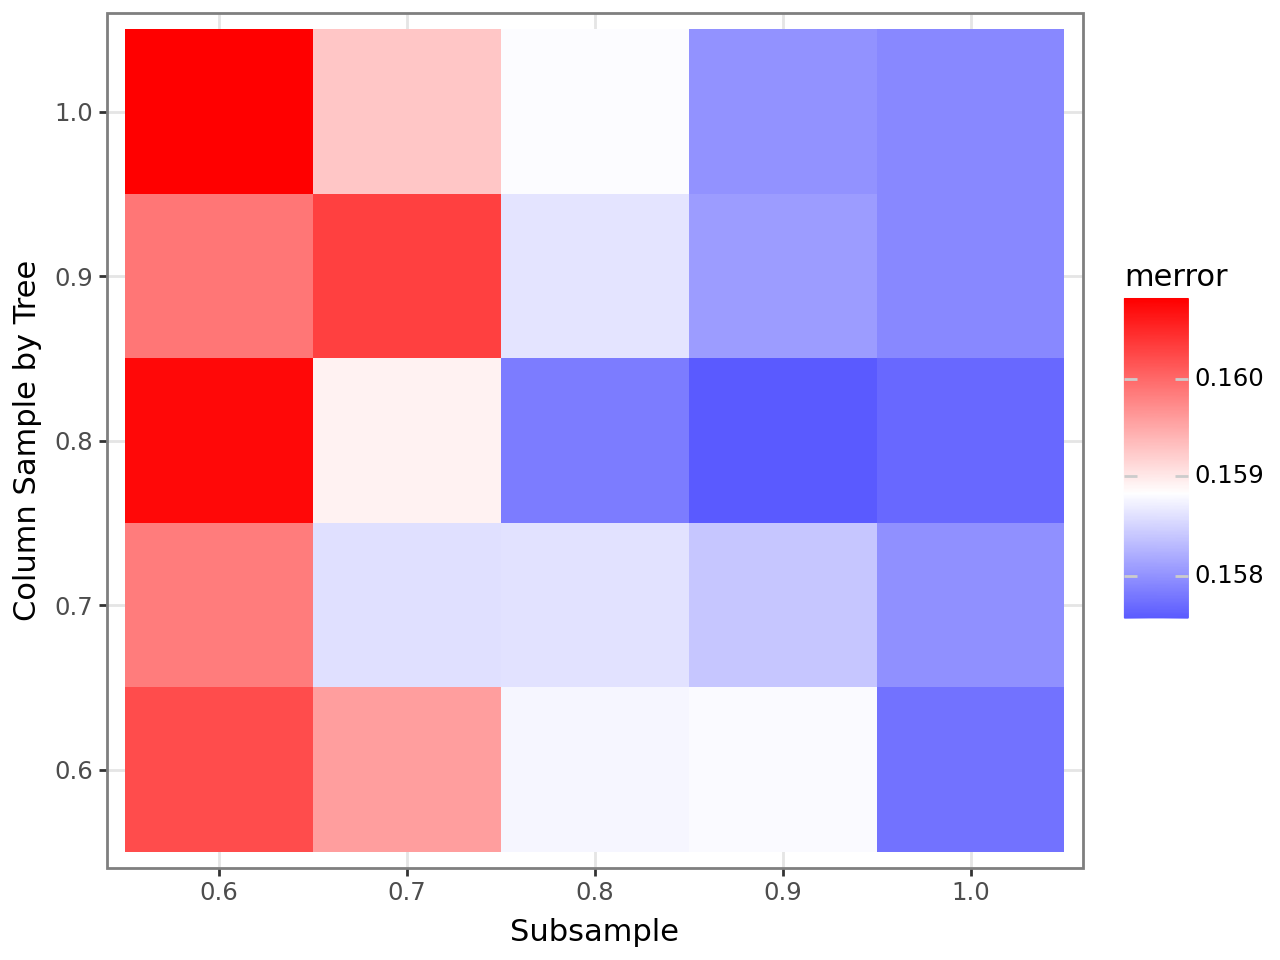

In [ ]:
if tuningflag:
  #tune subsample and colsample
  # Create grid of possible values
  grid = {
      "subsample":        [0.6, 0.7, 0.8, 0.9, 1.0],
      "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
  }
  # Convert into parameter grid and then list
  param_grid = list(ParameterGrid(grid))
  # Set base parameters
  base_params = {
      "objective": "multi:softmax", # Set objective
      "eval_metric": ["mlogloss", "merror"],  # set eval
      "eta": best_eta,
      "max_depth": max_depth, # Use tuned value for max depth
      "min_child_weight": min_child_weight, # Use tuned value for min child weight
      "gamma": best_gamma, # Use tuned value for gamma
      "tree_method": "hist",
      "seed": 111111,
      "nthread": 1,                     # single core
      "num_class": 4 # add num_class for multiclass objective
  }
  # Create function
  def run_one_cv(subsample, colsample_bytree):
      """Run xgb.cv for a single (subsample, colsample_bytree) and return best metrics."""
      params = base_params.copy() # Create copy of base parameters
      params.update({ # Update with values of subsample and colsample_bytree
          "subsample": float(subsample),
          "colsample_bytree": float(colsample_bytree),
      })
      # Run xgb.cv
      cv = xgb.cv(
          params=params,  # Set parameters
          dtrain=dtrain,  # Set training data
          num_boost_round=best_iter, # Set number of rounds
          nfold=5,  # Set cross-validation folds
          early_stopping_rounds=20, # Set number of early stopping rounds
          shuffle=True,
          verbose_eval=False,
          seed=111111, # Set seed
      )

      best_round = len(cv)             # early-stopped length
      best_row = cv.iloc[best_round - 1] # Identify best row
      # Return results
      return {
          "subsample": subsample,
          "colsample_bytree": colsample_bytree,
          "best_round": int(best_round),
          "test_merror": float(best_row["test-merror-mean"])
      }
  ### Be careful this can take a long time to run ###
  rows = [] # Create empty list to store results
  # For each set of parameters
  for p in tqdm(param_grid, desc="Subsample × Colsample_bytree CV (serial)"):
      rows.append(run_one_cv(p["subsample"], p["colsample_bytree"])) # Run tuning function and store results
  # Convert results into data frame
  sc_results = (pd.DataFrame(rows)
                  .sort_values(['test_merror'], ascending=True)
                  .reset_index(drop=True))

  # Identify best results
  best_sc = sc_results.iloc[0].to_dict()
  # Store best results
  print(f"Selected subsample={best_sc['subsample']}, "
        f"colsample_bytree={best_sc['colsample_bytree']} "
        f"(min test error={best_sc['test_merror']:.6f}, "
        f"best_round={best_sc['best_round']})")
  # Convert results table to have simpler names and drop round
  res_db = (
      sc_results[["subsample", "colsample_bytree", "test_merror"]]
      .rename(columns={
          "colsample_bytree": "colsample_by_tree",
          "test_merror": "merror"
      })
      .copy()
  )

  res_db["subsample"] = res_db["subsample"].astype("category")            # Convert tree number to factor for plotting
  res_db["colsample_by_tree"] = res_db["colsample_by_tree"].astype("category")  # Convert node size to factor for plotting


  merror_midpoint = res_db["merror"].mean() # Calculate mean merror

  # Create plot
  g_4 = (
      ggplot(res_db, aes(y="colsample_by_tree", x="subsample", fill="merror"))  # set aesthetics
      + geom_tile()                                                          # Use geom_tile for heatmap
      + theme_bw()                                                           # Set theme
      + scale_fill_gradient2(
          low="blue", mid="white", high="red",                               # Choose colors
          midpoint=merror_midpoint,                                             # Choose mid point
          na_value="grey",                                                   # Choose NA value
          guide="colorbar"                                                   # Set color bar (plotnine uses 'colorbar')
      )
      + labs(x="Subsample", y="Column Sample by Tree", fill="merror")           # Set labels
  )
  display(g_4)  # Generate plot

# Appendix B: Tuning XGBoost Gamma Deviance Regression

In [ ]:
tuningflag = False

In [ ]:
if tuningflag:
  #tuning iterations
  params = {
      "objective": "reg:gamma", # Set objective
      "eval_metric": ["gamma-deviance"],  # set eval  # Set objective
      "eta": 0.1,                       # Set learning rate
      "tree_method": "hist",
      "seed": 111111,
      "nthread": 1,                     # Parallel threads
  }

  # Run CV inside XGBoost
  cv_res = xgb.cv(
      params=params,
      dtrain=dtrain,              # Training data (DMatrix)
      num_boost_round=500,       # Number of rounds
      nfold=5,                    # 5-fold CV
      verbose_eval=100,            # Print every 20 iters
      shuffle=True,
  )

In [ ]:
if tuningflag:
  # Identify best iteration
  best_idx = cv_res['test-gamma-deviance-mean'].idxmin()
  best_iter = int(best_idx) + 1 # Increment by 1 to get iteration
  best_gamma  = float(cv_res.loc[best_idx, 'test-gamma-deviance-mean']) # Extract test error

  # Print results
  print(f"Best iteration (by min test error): {best_iter}")
  print(f"Min gamma at best iter: {best_gamma:.6f}")
  df_plot = cv_res.reset_index().rename(columns={"index": "iter"})
  df_plot["iter"] = df_plot["iter"] + 1  # 1-based

  # Safe column names (hyphens -> underscores) and ribbon bounds
  df_plot = df_plot.rename(columns=lambda c: c.replace("-", "_"))
  df_plot["test_gamma_lower"] = df_plot["test_gamma_deviance_mean"] - df_plot["test_gamma_deviance_std"]
  df_plot["test_gamma_upper"] = df_plot["test_gamma_deviance_mean"] + df_plot["test_gamma_deviance_std"]

  # Create plot
  p_err = (
      ggplot(df_plot, # Set data
            aes(x="iter", y="test_gamma_deviance_mean")) # Set X and Y
      + geom_line() # Set line
      + geom_ribbon(aes(ymin="test_gamma_lower", ymax="test_gamma_upper"), alpha=0.15) # Set error bounds
      + geom_vline(xintercept=best_iter, linetype="dashed", alpha=0.6) # Add vertical line at best iteration
      + theme_bw() # Set theme
      + labs( # Set labels
          title="XGBoost CV (no early stopping): Iterations vs gamma deviance",
          x="Boosting iteration",
          y="Test gamma deviance (mean ± 1 sd across folds)"
      )
  )
  # View plot
  p_err

In [ ]:
if tuningflag:
  df_long = df_plot.melt( # Melt data
      id_vars=["iter"],
      value_vars=["train_gamma_deviance_mean", "test_gamma_deviance_mean"],
      var_name="series",
      value_name="gamma"
  )
  # Create plot
  p_err_both = (
      ggplot(df_long, # Set data
            aes(x="iter", y="gamma", color="series")) # Set aesthetics
      + geom_line(alpha=0.9) # Set geom line
      + geom_vline(xintercept=best_iter, linetype="dashed", alpha=0.6) # Add vertical line for best iteration
      + theme_bw() # Set theme
      + labs( # Set labels
          title="Train vs Test gamma deviance over Boosting Iterations (no ES)",
          x="Boosting iteration",
          y="Error"
      )
  )
  # Display plot
  p_err_both

In [ ]:
if tuningflag:
  #Tune ETA
  # Set ETA values to try
  etas = [0.3, 0.2, 0.1, 0.05, 0.01]
  # Set base parameters
  base_params = {
      "objective": "reg:gamma", # Set objective
      "eval_metric": ["gamma-deviance"],  # set eval  # Set objective
      "tree_method": "hist",
      "seed": 111111,
      "nthread": 1,                     # Parallel threads
  }

  ### Be careful this can take a long time to run ###
  curves = []     # per-iteration logs for plotting
  summaries = []  # one row per eta
  # For each learning rate
  for eta in tqdm(etas, desc="Learning-rate CV (serial)"):
      params = base_params.copy() # Create copy of parmameters
      params["eta"] = float(eta) # Update ETA value
      # Apply xgb.cv
      cv = xgb.cv(
          params=params, # Set parameters
          dtrain=dtrain, # Set training data
          num_boost_round=384,  # run to optimal, determined before
          nfold=5, # Set folds for cross validation
          early_stopping_rounds=100, # Set early stopping rounds
          shuffle=True,
          verbose_eval=False,
          seed=111111,
      )

      # Extract data for model performance
      df_log = cv.reset_index().rename(columns={"index": "iter"})
      df_log["iter"] = df_log["iter"] + 1 # Increment iterations to get real number
      # fix hyphenated column names for plotnine
      df_log = df_log.rename(columns=lambda c: c.replace("-", "_"))
      df_log["eta"] = str(eta) # Store ETA value as a string
      curves.append(df_log) # Add values to data store

      # Identify best iteration
      best_round = len(cv)
      best_row = cv.iloc[best_round - 1] # Identify best row


      best_gamma = float(best_row["test-gamma-deviance-mean"]) # Extract best error value
      # Store results
      summaries.append({"eta": eta, "best_round": best_round, "test_gamma": best_gamma})

  # Combine curve data
  curves_df = pd.concat(curves, ignore_index=True)
  # Create data frame of result data
  summ_df = pd.DataFrame(summaries).sort_values(
      ["test_gamma"],
      ascending=True
  ).reset_index(drop=True)

  display(summ_df.head())

In [ ]:
if tuningflag:
  # Precompute ribbons (mean ± 1 sd) per-eta
  curves_df["y_lower"] = curves_df["test_gamma_deviance_mean"] - curves_df["test_gamma_deviance_std"]
  curves_df["y_upper"] = curves_df["test_gamma_deviance_mean"] + curves_df["test_gamma_deviance_std"]

  # Create plot
  p_lr = (
      ggplot(curves_df,  # Set dataset
            aes(x="iter", y="test_gamma_deviance_mean", color="eta", group="eta")) # Set Aesthetics
      + geom_line() # Set geom line
      + geom_ribbon(aes(ymin="y_lower", ymax="y_upper", fill="eta"), linetype="dashed", alpha=0.1, color="grey") # Add error bars
      + theme_bw() # Set theme
      + labs( # Set labels
          title="Learning Curves: Iterations vs Validation Gamma by Learning Rate",
          x="Boosting iteration",
          y=("Test gamma (mean ± 1 sd)" ),
          color="eta", fill="eta"
      )
  )
  # Display plot
  display(p_lr)

  best_eta = float(summ_df.iloc[0]["eta"]) # Extract best learning rate
  best_round = int(summ_df.iloc[0]["best_round"]) # Extract best round
  print(f"\nSelected eta={best_eta} with best_round={best_round}, " # Print results
        f"test_gamma={summ_df.iloc[0]['test_gamma']:.6f}")
  tuned_eta = float(best_eta) # Extract best learning rate

In [ ]:
if tuningflag:
  #tune max depth and min child weight
  # Set range of parameter values to try
  grid = {
      "max_depth": [7, 8, 9],
      "min_child_weight": [10, 20, 30]
  }
  param_grid = list(ParameterGrid(grid))

  # Set base model parameters
  base_params = {
      "objective": "reg:gamma", # Set objective
      "eval_metric": ["gamma-deviance"],  # set eval  # Set objective
      "eta": 0.10, #use max
      "tree_method": "hist",
      "seed": 111111,
      "nthread": 1,  # keep each worker single-threaded to avoid oversubscription
  }

  def run_one_cv(md, mcw):
      """Run xgb.cv for a single (max_depth, min_child_weight) pair and return best metrics."""
      params = base_params.copy()
      params.update({"max_depth": int(md), "min_child_weight": int(mcw)})

      cv = xgb.cv(
          params=params,
          dtrain=dtrain,              # DMatrix from earlier
          num_boost_round=384,        # nrounds = 100
          nfold=5,                    # 5-fold CV
          early_stopping_rounds=20,   # stop if no improvement
          shuffle=True,
          verbose_eval=False,
          seed=111111,
      )

      # Best round is the length of the early-stopped trace
      best_round = len(cv)

      # Read AUC & error at the best round row explicitly
      best_row = cv.iloc[best_round - 1]
      best_gamma = float(best_row["test-gamma-deviance-mean"])

      # Return results
      return {
          "max_depth": md,
          "min_child_weight": mcw,
          "best_round": best_round,
          "test_gamma": best_gamma
      }

  results = []
  for p in tqdm(param_grid, desc="Grid CV (serial)"):
      results.append(run_one_cv(p["max_depth"], p["min_child_weight"]))

  # Create and sort results data frame
  cv_results_df = (
      pd.DataFrame(results)
        .sort_values(["test_gamma"], ascending=True)
        .reset_index(drop=True)
  )

  # Identify best parameters0
  best_gamma = cv_results_df.iloc[0]
  print("Best gamma: ", best_gamma)

  # Create results data frame
  res_db = (
      cv_results_df[["max_depth", "min_child_weight", "test_gamma"]]
      .rename(columns={"test_gamma": "gamma"})
      .copy()
  )

  # Convert to categorical (factor) for plotting axes
  res_db["max_depth"] = res_db["max_depth"].astype("category")
  res_db["min_child_weight"] = res_db["min_child_weight"].astype("category")


  # Compute midpoints for diverging color scales
  gamma_midpoint = res_db["gamma"].mean()

  g_2 = (
      ggplot(res_db, aes(y="max_depth", x="min_child_weight", fill="gamma"))  # set aesthetics
      + geom_tile()                                                         # Use geom_tile for heatmap
      + theme_bw()                                                          # Set theme
      + scale_fill_gradient2(
          low="blue", mid="white", high="red",                              # Choose colors
          midpoint=gamma_midpoint,                                            # Choose mid point
          na_value="grey",                                                  # Choose NA value

      )
      + labs(x="Minimum Child Weight", y="Max Depth", fill="gamma")           # Set labels
  )
  g_2

In [ ]:
if tuningflag:
  #tune gamma
  gamma_vals = [0.00, 0.05, 0.10, 0.15, 0.20]
  #tune gamma

  # Set base parameters
  base_params = {
      "objective": "reg:gamma", # Set objective
      "eval_metric": ["gamma-deviance"],  # set eval  # Set objective
      "eta": 0.10,
      "max_depth": 8, # Use tuned value of max depth
      "min_child_weight": 30, # Use tuned value of min child weight
      "tree_method": "hist",
      "seed": 111111,
      "nthread": 1,
  }
  ### Be careful this can take a long time to run ###
  rows = [] # Create data frame to store valus
  for g in tqdm(gamma_vals, desc="Gamma CV (serial)"): # For each gamma value
      params = base_params.copy() # Create copy of base parameters
      params["gamma"] = float(g) # Replace value with current gamma value

      # Run xgb.cv
      cv = xgb.cv(
          params=params,
          dtrain=dtrain,                # Set training data
          num_boost_round=384,          # Set number of rounds
          nfold=5,                      # Set folds for cross validation
          early_stopping_rounds=20,     # Set early stopping rounds
          shuffle=True,
          verbose_eval=False,
          seed=111111, #Set seed
      )

      # Best iteration is the length of the early-stopped trace
      best_round = len(cv)
      best_row = cv.iloc[best_round - 1]
      # Store results from current iteration
      rows.append({
          "gamma": g,
          "best_round": int(best_round),
          "test_gd": float(best_row["test-gamma-deviance-mean"])
      })

  # Join results into data frame
  gamma_results = (pd.DataFrame(rows)
                    .sort_values(['test_gd'], ascending=True)
                    .reset_index(drop=True))
  # View results
  display(gamma_results)
  # Extract best value
  best_gamma = float(gamma_results.iloc[0]['gamma'])
  # Print out vest value
  print(f"Selected gamma: {best_gamma:.2f}")

In [ ]:
if tuningflag:
  #tune subsample and colsample
  # Create grid of possible values
  grid = {
      "subsample":        [0.6, 0.7, 0.8, 0.9, 1.0],
      "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
  }
  # Convert into parameter grid and then list
  param_grid = list(ParameterGrid(grid))
  # Set base parameters
  base_params = {
      "objective": "reg:gamma", # Set objective
      "eval_metric": ["gamma-deviance"],  # set eval  # Set objective
      "eta": 0.10,
      "max_depth": 8, # Use tuned value for max depth
      "min_child_weight": 30, # Use tuned value for min child weight
      "gamma": 0.20, # Use tuned value for gamma
      "tree_method": "hist",
      "seed": 111111,
      "nthread": 1,                     # single core
  }
  # Create function
  def run_one_cv(subsample, colsample_bytree):
      """Run xgb.cv for a single (subsample, colsample_bytree) and return best metrics."""
      params = base_params.copy() # Create copy of base parameters
      params.update({ # Update with values of subsample and colsample_bytree
          "subsample": float(subsample),
          "colsample_bytree": float(colsample_bytree),
      })
      # Run xgb.cv
      cv = xgb.cv(
          params=params,  # Set parameters
          dtrain=dtrain,  # Set training data
          num_boost_round=384, # Set number of rounds
          nfold=5,  # Set cross-validation folds
          early_stopping_rounds=20, # Set number of early stopping rounds
          shuffle=True,
          verbose_eval=False,
          seed=111111, # Set seed
      )

      best_round = len(cv)             # early-stopped length
      best_row = cv.iloc[best_round - 1] # Identify best row
      # Return results
      return {
          "subsample": subsample,
          "colsample_bytree": colsample_bytree,
          "best_round": int(best_round),
          "test_gd": float(best_row["test-gamma-deviance-mean"])
      }
  ### Be careful this can take a long time to run ###
  rows = [] # Create empty list to store results
  # For each set of parameters
  for p in tqdm(param_grid, desc="Subsample × Colsample_bytree CV (serial)"):
      rows.append(run_one_cv(p["subsample"], p["colsample_bytree"])) # Run tuning function and store results
  # Convert results into data frame
  sc_results = (pd.DataFrame(rows)
                  .sort_values(['test_gd'], ascending=True)
                  .reset_index(drop=True))

  # Identify best results
  best_sc = sc_results.iloc[0].to_dict()
  # Store best results
  print(f"Selected subsample={best_sc['subsample']}, "
        f"colsample_bytree={best_sc['colsample_bytree']} "
        f"(min gamma deviance={best_sc['test_gd']:.6f}, "
        f"best_round={best_sc['best_round']})")
  # Convert results table to have simpler names and drop round
  res_db = (
      sc_results[["subsample", "colsample_bytree", "test_gd"]]
      .rename(columns={
          "colsample_bytree": "colsample_by_tree",
          "test_gd": "gamma_deviance"
      })
      .copy()
  )

  res_db["subsample"] = res_db["subsample"].astype("category")            # Convert tree number to factor for plotting
  res_db["colsample_by_tree"] = res_db["colsample_by_tree"].astype("category")  # Convert node size to factor for plotting


  gamma_midpoint = res_db["gamma_deviance"].mean() # Calculate mean AUC

  # Create plot
  g_4 = (
      ggplot(res_db, aes(y="colsample_by_tree", x="subsample", fill="gamma_deviance"))  # set aesthetics
      + geom_tile()                                                          # Use geom_tile for heatmap
      + theme_bw()                                                           # Set theme
      + scale_fill_gradient2(
          low="blue", mid="white", high="red",                               # Choose colors
          midpoint=gamma_midpoint,                                             # Choose mid point
          na_value="grey",                                                   # Choose NA value
          guide="colorbar"                                                   # Set color bar (plotnine uses 'colorbar')
      )
      + labs(x="Subsample", y="Column Sample by Tree", fill="gamma_deviance")           # Set labels
  )
  display(g_4)  # Generate plot